In [1]:
import geopandas as gpd
import contextily as cx
import pandas as pd
%matplotlib inline
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from datetime import date

In [2]:
datapath = '/Users/zhu/Dropbox/Database/Hera/AQS/'
#datapath = '/Users/zhu/Dropbox/Database/Hera/airnow-transfer/'
shapefile = gpd.read_file(r"/Users/zhu/Dropbox/Database/Hera/LA_Merge/LA_Merge.shp")

In [3]:
#wrf_files = ['aqs_wrf_chem_vcp_noI_phot_4km.pkl','aqs_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.pkl']
wrf_files = ['aqs_wrf_chem_vcp_noI_phot_4km.pkl','aqs_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.pkl']


In [4]:
recap_months = [6]*30 + [8]*31 + [9]*6
recap_days = list(range(1,31)) + list(range(1,32)) + list(range(1,7))


def read_df_wrfs(filename):
    df_wrf = pd.DataFrame()
    for this_month, this_day in zip(recap_months,recap_days):
        output_filename_thisday = datapath + '2021-{:02d}-{:02d}-'.format(this_month,this_day) + filename
        #print(output_filename_thisday)
        df_wrf_thisday = pd.read_pickle(output_filename_thisday)
        df_wrf_thisday['day'] = this_day    
        idx = (df_wrf_thisday['latitude'] <= 34.2) & (df_wrf_thisday['latitude'] >= 33.6) & (df_wrf_thisday['longitude'] >= -118.82) & (df_wrf_thisday['longitude'] <= -117)
        df_wrf_thisday = df_wrf_thisday.loc[idx,:]
        df_wrf_thisday = df_wrf_thisday.dropna(subset='o3')
        df_wrf = pd.concat([df_wrf, df_wrf_thisday])
    return df_wrf


df_wrfs = []
for i in range(len(wrf_files)):
    filename = wrf_files[i]
    df_wrf = read_df_wrfs(filename)
    df_wrf = df_wrf.set_index('time_local')
    df_wrf['day'] = df_wrf.index.day
    df_wrf['date'] = df_wrf.index.date
    df_wrf['month'] = df_wrf.index.month
    df_wrf['hour'] = df_wrf.index.hour
    df_wrf['weekday'] = df_wrf.index.weekday
    temp_index = df_wrf['TEMP']<0
    df_wrf.loc[temp_index, 'TEMP'] = np.nan
    df_wrf['OZONE'] = df_wrf['OZONE']*1e3
    df_wrf = df_wrf.reset_index()
    df_wrfs.append(df_wrf)
    
gdfs = []
for j in range(len(df_wrfs)):
    print(j)
    df_wrf = df_wrfs[j]
    cls_indxs = []
    
    for i in range(len(df_wrf['longitude'].values)):
        point = Point(df_wrf['longitude'].values[i], df_wrf['latitude'].values[i])
        classdefs = shapefile.loc[:,'geometry'].contains(point)
        classdefs_index = [i for i, x in enumerate(classdefs) if x]
        if len(classdefs_index) == 1:
            cls_indxs.append(classdefs_index[0])
        else:
            cls_indxs.append(5)
    df_wrf['cls_indxs'] = cls_indxs
    df_wrf['longitude'] = np.round(df_wrf['longitude'],2)
    indx = df_wrf['longitude'] == -118.18
    df_wrf.loc[indx,'longitude'] = -118.17
    areas= shapefile['MERGE_SRC'].values

    names = []
    for i_indx in range(len(cls_indxs)):
        if cls_indxs[i_indx] == 5:
            names.append('Outside')
        else:
            names.append(areas[cls_indxs[i_indx]])
    df_wrf.loc[:,'area'] = names
    
    gdfs.append(gpd.GeoDataFrame(
        df_wrf, geometry=gpd.points_from_xy(df_wrf['longitude'], df_wrf['latitude'])))

0
1


In [71]:
lons

array([-118.43, -118.23, -118.2 , -118.17, -118.13, -118.07, -117.95,
       -117.94, -117.92, -117.75, -117.63, -117.62, -117.53, -117.49,
       -117.42, -117.27])

In [74]:
indx = (df_wrfs[0]['longitude'] == lons[4]) 
df_pasadena = df_wrfs[0].loc[indx,:]
df_pasadena = df_pasadena.dropna(subset=['OZONE','o3'])


indx = (df_wrfs[1]['longitude'] == lons[4]) 
df_pasadena_v1 = df_wrfs[1].loc[indx,:]
df_pasadena_v1 = df_pasadena_v1.dropna(subset=['OZONE','o3'])

Text(0.5, 0, '')

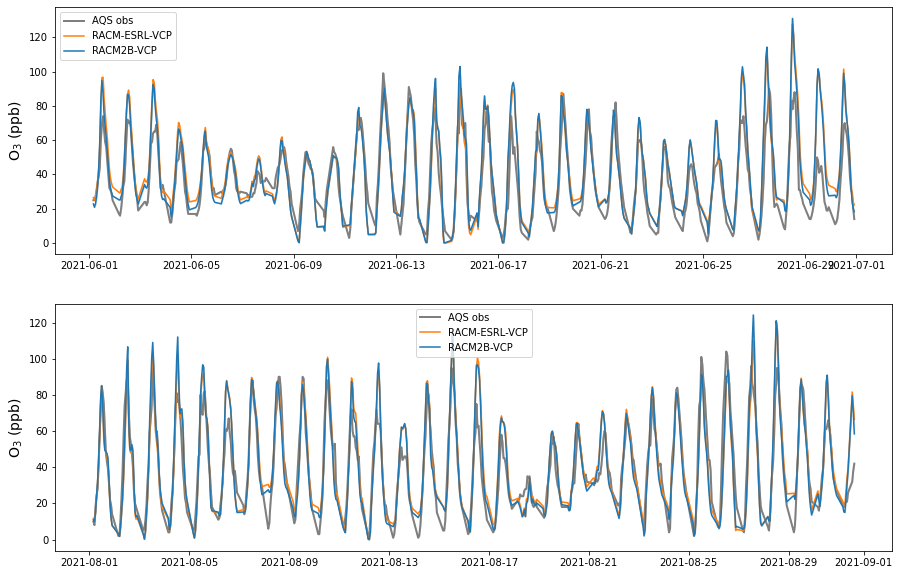

In [75]:
plt.figure(figsize=(15,10))
#plt.subplot(3,1,1)
#sns.lineplot(x='hour',y='OZONE',data=df_pasadena)
#sns.lineplot(x='hour',y='o3',data=df_pasadena)

plt.subplot(2,1,1)
sns.lineplot(x='time_local',y='OZONE',data=df_pasadena.query('month==6'),label='AQS obs',color='tab:gray',linewidth=2)
sns.lineplot(x='time_local',y='o3',data=df_pasadena.query('month==6'),label='RACM-ESRL-VCP',color='tab:orange')
sns.lineplot(x='time_local',y='o3',data=df_pasadena_v1.query('month==6'),label='RACM2B-VCP',color='tab:blue')
plt.ylabel('O$_3$ (ppb)',fontsize=14)
plt.xlabel('')

plt.subplot(2,1,2)
sns.lineplot(x='time_local',y='OZONE',data=df_pasadena.query('month==8'),label='AQS obs',color='tab:gray',linewidth=2)
sns.lineplot(x='time_local',y='o3',data=df_pasadena.query('month==8'),label='RACM-ESRL-VCP',color='tab:orange')
sns.lineplot(x='time_local',y='o3',data=df_pasadena_v1.query('month==8'),label='RACM2B-VCP',color='tab:blue')
plt.ylabel('O$_3$ (ppb)',fontsize=14)
plt.xlabel('')

In [58]:
df_pasadena.groupby('month')['OZONE','o3'].corr()**2

/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_20188/2218187814.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_pasadena.groupby('month')['OZONE','o3'].corr()**2


OZONE        o3
month                          
6     OZONE  1.000000  0.678970
      o3     0.678970  1.000000
8     OZONE  1.000000  0.801872
      o3     0.801872  1.000000
9     OZONE  1.000000  0.794789
      o3     0.794789  1.000000

Text(0.5, 0, '')

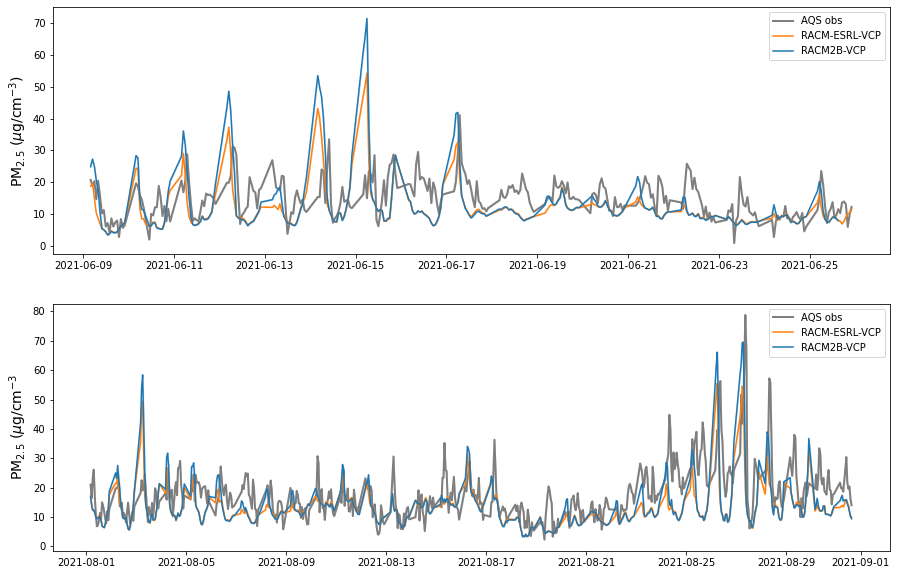

In [114]:
plt.figure(figsize=(15,10))
#plt.subplot(3,1,1)
#sns.lineplot(x='hour',y='OZONE',data=df_pasadena)
#sns.lineplot(x='hour',y='o3',data=df_pasadena)
indx = (df_wrfs[0]['longitude'] == lons[11]) 
this_df = df_wrfs[0].loc[indx,:]
#print(this_df.dropna(subset=['PM2_5_DRY','PM2.5']).shape)
this_df = this_df.dropna(subset=['PM2_5_DRY','PM2.5'])


indx = (df_wrfs[1]['longitude'] == lons[11]) 
this_df_v1 = df_wrfs[1].loc[indx,:]
this_df_v1 = this_df_v1.dropna(subset=['PM2_5_DRY','PM2.5'])

plt.subplot(2,1,1)
sns.lineplot(x='time_local',y='PM2.5',data=this_df.query('month==6 & day >8 & day<26'),label='AQS obs',color='tab:gray',linewidth=2)
#sns.lineplot(x='time_local',y='PM2.5',data=this_df_v1.query('month==6'),label='AQS obs',color='tab:gray',linewidth=2)
sns.lineplot(x='time_local',y='PM2_5_DRY',data=this_df.query('month==6 & day >8 & day<26'),label='RACM-ESRL-VCP',color='tab:orange')
sns.lineplot(x='time_local',y='PM2_5_DRY',data=this_df_v1.query('month==6 & day >8 & day<26'),label='RACM2B-VCP',color='tab:blue')
plt.ylabel('PM$_{2.5}$ ($\mu$g/cm$^{-3}$)',fontsize=14)
plt.xlabel('')

plt.subplot(2,1,2)
sns.lineplot(x='time_local',y='PM2.5',data=this_df.query('month==8'),label='AQS obs',color='tab:gray',linewidth=2)
sns.lineplot(x='time_local',y='PM2_5_DRY',data=this_df.query('month==8'),label='RACM-ESRL-VCP',color='tab:orange')
sns.lineplot(x='time_local',y='PM2_5_DRY',data=this_df_v1.query('month==8'),label='RACM2B-VCP',color='tab:blue')
plt.ylabel('PM$_{2.5}$ ($\mu$g/cm$^{-3}$',fontsize=14)
plt.xlabel('')

Text(0.5, 0, 'Local hour')

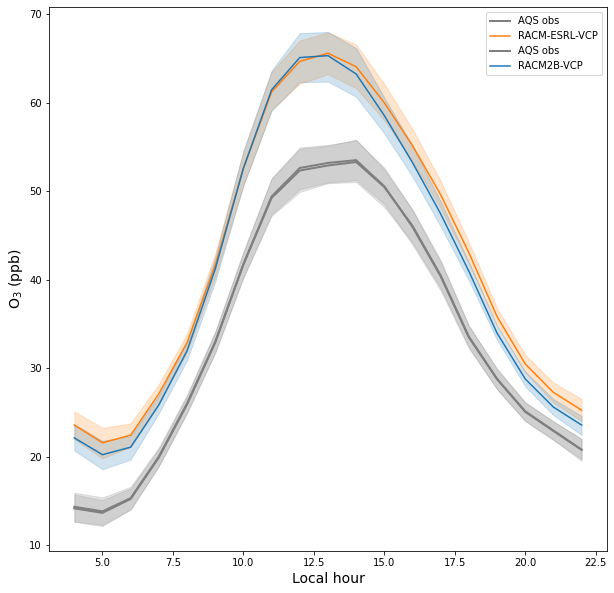

In [52]:
plt.figure(figsize=(10,10))
#plt.subplot(3,1,1)
sns.lineplot(x='hour',y='OZONE',data=df_pasadena,color='tab:gray',label='AQS obs',linewidth=2)
sns.lineplot(x='hour',y='o3',data=df_pasadena,color='tab:orange',label='RACM-ESRL-VCP')
sns.lineplot(x='hour',y='OZONE',data=df_pasadena_v1,color='tab:gray',label='AQS obs',linewidth=2)

sns.lineplot(x='hour',y='o3',data=df_pasadena_v1,color='tab:blue',label='RACM2B-VCP')
plt.ylabel('O$_3$ (ppb)',fontsize=14)
plt.xlabel('Local hour',fontsize=14)

In [78]:
#plt.figure(figsize=(15,8))

corr_esrl_o3 = []
corr_racm2b_o3 = []
nmb_esrl_o3 = []
nmb_racm2b_o3 = []
corr_esrl_pm25 = []
corr_racm2b_pm25 = []
nmb_esrl_pm25 = []
nmb_racm2b_pm25 = []

lons = np.sort(gdfs[0].query('cls_indxs<5')['longitude'].unique())
for i_lon,lon in enumerate(lons):
    indx = (df_wrfs[0]['longitude'] == lon) 
    this_df = df_wrfs[0].loc[indx,:]
    #this_df = this_df.dropna(subset=['OZONE','o3'])

    indx = (df_wrfs[1]['longitude'] == lon) 
    this_df_v1 = df_wrfs[1].loc[indx,:]
    #this_df_v1 = this_df_v1.dropna(subset=['OZONE','o3'])
    
    this_df = this_df.query('month==6')
    this_df_v1 = this_df_v1.query('month==6')
    corr_esrl_o3.append(this_df['o3'].corr(this_df['OZONE']))
    corr_racm2b_o3.append(this_df_v1['o3'].corr(this_df_v1['OZONE']))
    nmb_esrl_o3.append((np.nanmean(this_df['o3']) - np.nanmean(this_df['OZONE']))/np.nanmean(this_df['OZONE']))
    nmb_racm2b_o3.append((np.nanmean(this_df_v1['o3']) - np.nanmean(this_df_v1['OZONE']))/np.nanmean(this_df_v1['OZONE']))
    
    corr_esrl_pm25.append(this_df['PM2_5_DRY'].corr(this_df['PM2.5']))
    corr_racm2b_pm25.append(this_df_v1['PM2_5_DRY'].corr(this_df_v1['PM2.5']))
    nmb_esrl_pm25.append((np.nanmean(this_df['PM2_5_DRY']) - np.nanmean(this_df['PM2.5']))/np.nanmean(this_df['PM2.5']))
    nmb_racm2b_pm25.append((np.nanmean(this_df_v1['PM2_5_DRY']) - np.nanmean(this_df_v1['PM2.5']))/np.nanmean(this_df_v1['PM2.5']))

    #plt.subplot(3,6,i_lon+1)
    #sns.lineplot(x='hour',y='OZONE',data=this_df,color='tab:gray',linewidth=2)
    #sns.lineplot(x='hour',y='o3',data=this_df,color='tab:orange')
    #sns.lineplot(x='hour',y='o3',data=this_df_v1,color='tab:blue')
    #plt.title(lon, fontsize=14)
    #plt.ylabel('O$_3$ (ppb)',fontsize=14)
#plt.tight_layout()


corr_esrl_o3 = np.array(corr_esrl_o3)
corr_racm2b_o3 = np.array(corr_racm2b_o3)
nmb_esrl_o3 = np.array(nmb_esrl_o3)
nmb_racm2b_o3 = np.array(nmb_racm2b_o3)
corr_esrl_pm25 = np.array(corr_esrl_pm25)
corr_racm2b_pm25 = np.array(corr_racm2b_pm25)
nmb_esrl_pm25 = np.array(nmb_esrl_pm25)
nmb_racm2b_pm25 = np.array(nmb_racm2b_pm25)


/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_20188/454193391.py:31: RuntimeWarning: Mean of empty slice
  nmb_esrl_pm25.append((np.nanmean(this_df['PM2_5_DRY']) - np.nanmean(this_df['PM2.5']))/np.nanmean(this_df['PM2.5']))
/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_20188/454193391.py:32: RuntimeWarning: Mean of empty slice
  nmb_racm2b_pm25.append((np.nanmean(this_df_v1['PM2_5_DRY']) - np.nanmean(this_df_v1['PM2.5']))/np.nanmean(this_df_v1['PM2.5']))
/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_20188/454193391.py:26: RuntimeWarning: Mean of empty slice
  nmb_esrl_o3.append((np.nanmean(this_df['o3']) - np.nanmean(this_df['OZONE']))/np.nanmean(this_df['OZONE']))
/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_20188/454193391.py:27: RuntimeWarning: Mean of empty slice
  nmb_racm2b_o3.append((np.nanmean(this_df_v1['o3']) - np.nanmean(this_df_v1['OZONE']))/np.nanmean(this_df_v1['OZONE']))


In [79]:
stat_df = pd.DataFrame()
stat_df.loc[:,'lon'] = lons


stat_df.loc[:,'nmb_esrl_o3'] = nmb_esrl_o3
stat_df.loc[:,'corr_esrl_o3'] = corr_esrl_o3**2
stat_df.loc[:,'nmb_racm2b_o3'] = nmb_racm2b_o3
stat_df.loc[:,'corr_racm2b_o3'] = corr_racm2b_o3**2

stat_df.loc[:,'nmb_esrl_pm25'] = nmb_esrl_pm25
stat_df.loc[:,'corr_esrl_pm25'] = corr_esrl_pm25**2
stat_df.loc[:,'nmb_racm2b_pm25'] = nmb_racm2b_pm25
stat_df.loc[:,'corr_racm2b_pm25'] = corr_racm2b_pm25**2
stat_df

lon  nmb_esrl_o3  corr_esrl_o3  nmb_racm2b_o3  corr_racm2b_o3  \
0  -118.43     0.188203      0.541632       0.138958        0.505657   
1  -118.23     0.129939      0.743590       0.093042        0.740990   
2  -118.20     0.046563      0.617343       0.008788        0.630511   
3  -118.17    -0.017765      0.483221      -0.058595        0.472022   
4  -118.13     0.153200      0.778360       0.135987        0.792166   
5  -118.07     0.222786      0.723150       0.192271        0.735118   
6  -117.95     0.307284      0.678970       0.271622        0.694134   
7  -117.94     0.259462      0.678720       0.212289        0.680034   
8  -117.92     0.134077      0.801839       0.108807        0.817264   
9  -117.75     0.246435      0.839296       0.234603        0.855871   
10 -117.63     0.218011      0.862141       0.212848        0.878243   
11 -117.62          NaN           NaN            NaN             NaN   
12 -117.53          NaN           NaN            NaN             NaN   
13 -117.49     0.130509      0.862299       0.115297        0.871376   
14 -117.42     0.171753      0.829924       0.149625        0.839645   
15 -117.27     0.119641      0.862814       0.109105        0.868586   

    nmb_esrl_pm25  corr_esrl_pm25  nmb_racm2b_pm25  corr_racm2b_pm25  
0             NaN             NaN              NaN               NaN  
1             NaN             NaN              NaN               NaN  
2        0.053376        0.031293         0.010996          0.029372  
3       -0.149114        0.034906        -0.166161          0.058789  
4             NaN             NaN              NaN               NaN  
5             NaN             NaN              NaN               NaN  
6             NaN             NaN              NaN               NaN  
7        0.082451        0.077776         0.030363          0.121218  
8             NaN             NaN              NaN               NaN  
9             NaN             NaN              NaN               NaN  
10            NaN             NaN              NaN               NaN  
11      -0.144599        0.143982        -0.138124          0.210040  
12            NaN             NaN              NaN               NaN  
13            NaN             NaN              NaN               NaN  
14       0.295593        0.277181         0.232025          0.290944  
15            NaN             NaN              NaN               NaN

In [120]:
nmb_esrl_o3

array([ 0.10673178,  0.0759328 , -0.02054475, -0.08028295,  0.09207929,
        0.18020718,  0.2453361 ,  0.2060595 ,  0.13402159,  0.19981547,
        0.18494842,         nan,         nan,  0.10645532,  0.11268   ,
        0.10271918])

In [121]:
corr_esrl_o3

array([0.71347193, 0.87632329, 0.80356813, 0.73648875, 0.89546716,
       0.88154239, 0.86445535, 0.84386326, 0.92255682, 0.92740123,
       0.93448219,        nan,        nan, 0.93528157, 0.93207554,
       0.92376213])

In [14]:
indx = (np.round(df_wrfs[0]['longitude'],1) == -118.0) & (np.round(df_wrfs[0]['latitude'],1) == 33.9) 
df_pasadena = df_wrfs[0].loc[indx,:]
df_pasadena = df_pasadena.query('hour==12').groupby(['time_local','date']).mean().reset_index()

df_pasadena.loc[:,'temp_index'] = '25 <= T < 30'
df_pasadena.loc[:,'col'] = 'chocolate'
df_pasadena.loc[:,'temp_bin_index'] = 1
indx = (df_pasadena['TEMP']<25)
df_pasadena.loc[indx,'temp_index'] = 'T < 25'
df_pasadena.loc[indx,'col'] = 'peachpuff'
df_pasadena.loc[indx,'temp_bin_index'] = 0
indx = (df_pasadena['TEMP']>=30)
df_pasadena.loc[indx,'temp_index'] = '30 <= T < 37'
df_pasadena.loc[indx,'col'] = 'saddlebrown'
df_pasadena.loc[indx,'temp_bin_index'] = 2
#temp_bin =pd.cut(df_pasadena['TEMP'], bins = np.linspace(df_pasadena['TEMP'].min()-0.5,df_pasadena['TEMP'].max()+0.5,4))
#df_pasadena['temp_bin_index'] = LabelEncoder().fit_transform(temp_bin)

temp = df_pasadena[['time_local','date','TEMP','temp_index','temp_bin_index']]
#temp.to_csv(datapath+'temp_bin.csv')


In [15]:
temp

time_local        date       TEMP    temp_index  temp_bin_index
0  2021-06-01 12:00:00  2021-06-01  24.990000        T < 25               0
1  2021-06-02 12:00:00  2021-06-02  24.434444        T < 25               0
2  2021-06-03 12:00:00  2021-06-03  23.323333        T < 25               0
3  2021-06-04 12:00:00  2021-06-04  22.767778        T < 25               0
4  2021-06-05 12:00:00  2021-06-05  23.878889        T < 25               0
..                 ...         ...        ...           ...             ...
63 2021-09-03 12:00:00  2021-09-03  27.767778  25 <= T < 30               1
64 2021-09-04 12:00:00  2021-09-04  33.878889  30 <= T < 37               2
65 2021-09-05 12:00:00  2021-09-05  36.101111  30 <= T < 37               2
66 2021-09-06 12:00:00  2021-09-06  28.323333  25 <= T < 30               1
67 2021-09-07 12:00:00  2021-09-07  28.323333  25 <= T < 30               1

[68 rows x 5 columns]

In [7]:
df_pasadena.loc[69,'date']=date(2021,7,1)
df_pasadena.loc[69,'TEMP']=0
df_pasadena.loc[69,'col']='white'
df_pasadena.loc[70,'date']=date(2021,7,2)
df_pasadena.loc[70,'TEMP']=0
df_pasadena.loc[70,'col']='white'
df_pasadena = df_pasadena.sort_values(by='date')

(-1.0, 71.0)

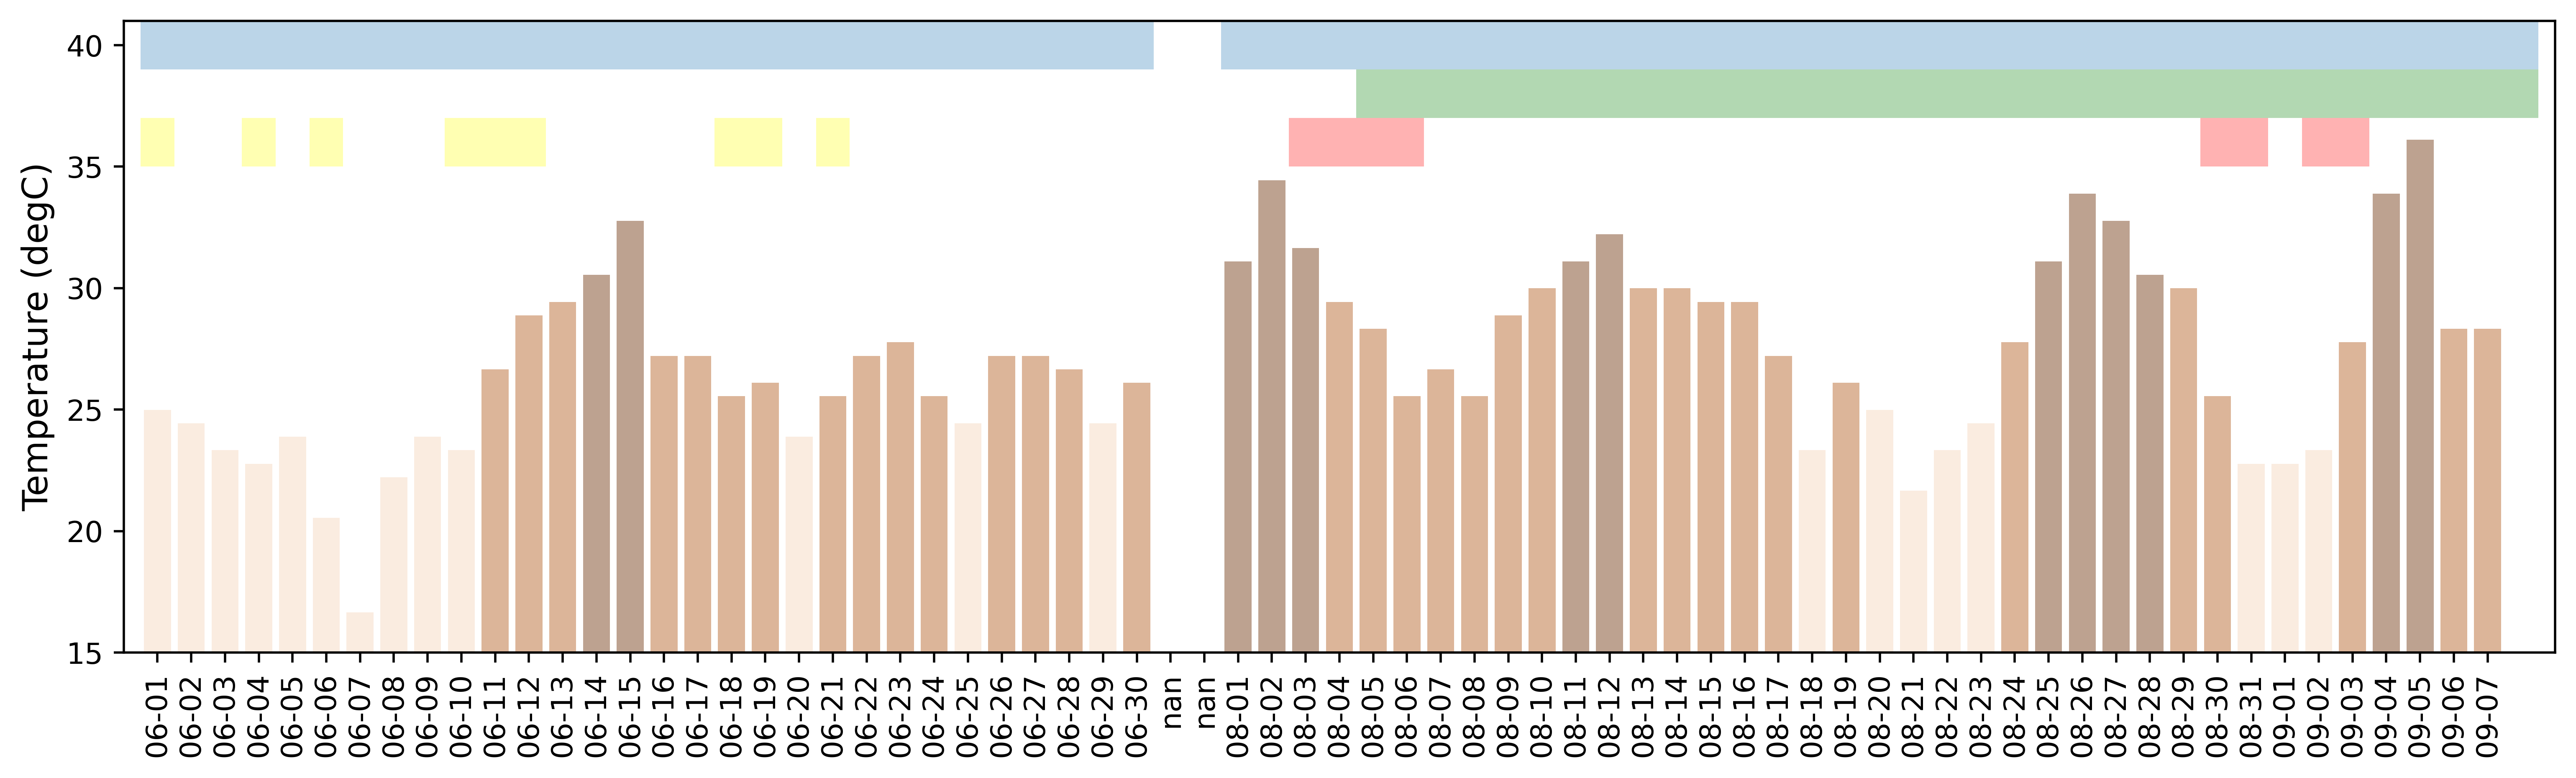

In [8]:
# PLOTTING
recap_days =[1,4,6,10,11,12,18,19,21]
mobile_days = [3,4,5,6,30,31,2+31,3+31]
mobile_days = [day+32 for day in mobile_days]
ground_days = list(range(5,32))+list(range(1+31,9+31))
ground_days = [day+32 for day in ground_days]

fig, ax = plt.subplots(figsize = (15,4),dpi=500) 

fill_range_max= [37,37]
fill_range_min= [35,35]
for this_day in recap_days:
    ax.fill_between([this_day-0.5-1,this_day+0.5-1],fill_range_min,fill_range_max, facecolor='yellow',edgecolor='None',alpha=0.3)
for this_day in mobile_days:
    ax.fill_between([this_day-0.5-1,this_day+0.5-1],fill_range_min,fill_range_max, facecolor='red',edgecolor='None',alpha=0.3)

fill_range_max= [39,39]
fill_range_min= [37,37]
for this_day in ground_days:
    ax.fill_between([this_day-0.5-1,this_day+0.5-1],fill_range_min,fill_range_max, facecolor='green',edgecolor='None',alpha=0.3)

fill_range_max= [41,41]
fill_range_min= [39,39]
ax.fill_between([-0.5,29.5],fill_range_min,fill_range_max, facecolor='tab:blue',edgecolor='None',alpha=0.3)

ax.fill_between([31.5,70.5],fill_range_min,fill_range_max, facecolor='tab:blue',edgecolor='None',alpha=0.3)

#sns.barplot(x='date',y='TEMP',hue='temp_bin_index',data=df_pasadena,palette=sns.color_palette("rocket_r"),alpha=0.5)
sns.barplot(x='date',y='TEMP',data=df_pasadena,alpha=0.5, palette=df_pasadena['col'].values)
x_dates = df_pasadena['time_local'].dt.strftime('%m-%d')
ax.set_xticklabels(labels=x_dates, rotation=90,fontsize=10)
plt.ylabel('Temperature (degC)',fontsize=12)
plt.xlabel('')
#plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim([15,41])
plt.xlim([-1,71])
#plt.show()
#plt.savefig('/Users/zhu/Dropbox/Publications/2023-RACM2B_VCP/Figures-v2/summary_observations_v0.pdf', format='pdf')


In [16]:
temp

time_local        date       TEMP    temp_index  temp_bin_index
0  2021-06-01 12:00:00  2021-06-01  24.990000        T < 25               0
1  2021-06-02 12:00:00  2021-06-02  24.434444        T < 25               0
2  2021-06-03 12:00:00  2021-06-03  23.323333        T < 25               0
3  2021-06-04 12:00:00  2021-06-04  22.767778        T < 25               0
4  2021-06-05 12:00:00  2021-06-05  23.878889        T < 25               0
..                 ...         ...        ...           ...             ...
63 2021-09-03 12:00:00  2021-09-03  27.767778  25 <= T < 30               1
64 2021-09-04 12:00:00  2021-09-04  33.878889  30 <= T < 37               2
65 2021-09-05 12:00:00  2021-09-05  36.101111  30 <= T < 37               2
66 2021-09-06 12:00:00  2021-09-06  28.323333  25 <= T < 30               1
67 2021-09-07 12:00:00  2021-09-07  28.323333  25 <= T < 30               1

[68 rows x 5 columns]

In [6]:
mdas = []
gmdas = []
for i in range(len(gdfs)):
    mda = pd.DataFrame()

    lons = np.sort(gdfs[i].query('cls_indxs<5')['longitude'].unique())
    dates = gdfs[i]['date'].unique()[:-1]
    n=0
    for i_lon, lon in enumerate(lons):
        for date in dates:

            indx = (gdfs[i]['date'] == date) & (gdfs[0]['longitude'] == lon) 
            if len(gdfs[i].loc[indx,'latitude'].values)>0:
                this_gdf = gdfs[i].loc[indx,:].dropna(subset=['OZONE']).groupby(['time_local']).mean()
                mda.loc[n, 'OZONE'] = this_gdf.sort_values(by='OZONE', ascending=False)['OZONE'][:8].mean()
                mda.loc[n, 'o3'] = this_gdf.sort_values(by='o3', ascending=False)['o3'][:8].mean()

                this_gdf = gdfs[i].loc[indx,:].dropna(subset=['PM2.5'])
                mda.loc[n, 'PM2_5_DRY'] = this_gdf['PM2_5_DRY'].mean()
                mda.loc[n, 'PM2.5'] = this_gdf['PM2.5'].mean()

                this_gdf = gdfs[i].loc[indx,:].dropna(subset=['TEMP'])
                mda.loc[n, 'TEMP'] = this_gdf['TEMP'].mean()
                #print(gdfs[0].loc[indx,:].sort_values(by='OZONE', ascending=False)[['time_local','OZONE']])
                mda.loc[n, 'latitude'] = gdfs[i].loc[indx,'latitude'].values[0]
                mda.loc[n, 'longitude'] = lon
                mda.loc[n, 'date'] = date
                mda.loc[n, 'weekday'] = gdfs[i].loc[indx,'weekday'].values[0]
                #mda.loc[n, 'scale'] = scale[i]
                n = n+1

    indx = (mda.loc[:, 'longitude'] <= -117.93) | (mda.loc[:, 'longitude'] >= -117.7)
    mda = mda.loc[indx,:]

    cls_indxs = []
    for j in range(len(mda['longitude'].values)):
        point = Point(mda['longitude'].values[j], mda['latitude'].values[j])
        classdefs = shapefile.loc[:,'geometry'].contains(point)
        classdefs_index = [k for k, x in enumerate(classdefs) if x]
        if len(classdefs_index) == 1:
            cls_indxs.append(classdefs_index[0])
        else:
            cls_indxs.append(5)

    mda['cls_indxs'] = cls_indxs

    areas= shapefile['MERGE_SRC'].values

    names = []
    for i_indx in range(len(cls_indxs)):
        if cls_indxs[i_indx] == 5:
            names.append('Outside')
        else:
            names.append(areas[cls_indxs[i_indx]])
    mda.loc[:,'area'] = names
    gmda = gpd.GeoDataFrame(mda, geometry=gpd.points_from_xy(mda['longitude'], mda['latitude']))
    mdas.append(mda)
    gmdas.append(gmda)

In [7]:
#temp = mda.groupby(['date'])['TEMP'].mean().reset_index()
#temp_bin =pd.cut(temp['TEMP'], bins = np.linspace(temp['TEMP'].min()-0.5,temp['TEMP'].max()+0.5,4))
#temp['temp_bin_index'] = LabelEncoder().fit_transform(temp_bin)
for i in range(len(mdas)):
    gmdas[i] = gmdas[i].merge(temp,on='date')
    mdas[i] = mdas[i].merge(temp,on='date')

In [20]:
mdas[0]

OZONE          o3  PM2_5_DRY      PM2.5     TEMP_x   latitude  \
0    37.3750   55.911926        NaN        NaN        NaN  33.955070   
1    49.8750   64.787834        NaN        NaN  19.200526  34.066590   
2    47.2500   61.504799  18.951797  14.105263  18.849649  33.901389   
3    46.6250   57.250290  13.388743  13.526316  18.235614  33.792360   
4    59.6250   77.422180        NaN        NaN        NaN  34.132600   
..       ...         ...        ...        ...        ...        ...   
933      NaN         NaN  12.738130  21.164516        NaN  34.030833   
934      NaN         NaN        NaN        NaN        NaN  34.068120   
935  77.3125   95.965446        NaN        NaN  26.837670  33.996360   
936  73.3750   92.900177  12.666389  17.709678        NaN  33.999580   
937  90.8750  103.913437        NaN        NaN        NaN  34.106678   

     longitude        date  weekday  cls_indxs                area  \
0      -118.43  2021-06-01      1.0          3             CoastLA   
1      -118.23  2021-06-01      1.0          0          DowntownLA   
2      -118.20  2021-06-01      1.0          0          DowntownLA   
3      -118.17  2021-06-01      1.0          3             CoastLA   
4      -118.13  2021-06-01      1.0          1  SanBernadinoValley   
..         ...         ...      ...        ...                 ...   
933    -117.62  2021-09-06      0.0          1  SanBernadinoValley   
934    -117.53  2021-09-06      0.0          1  SanBernadinoValley   
935    -117.49  2021-09-06      0.0          1  SanBernadinoValley   
936    -117.42  2021-09-06      0.0          1  SanBernadinoValley   
937    -117.27  2021-09-06      0.0          1  SanBernadinoValley   

                        geometry          time_local     TEMP_y    temp_index  \
0    POINT (-118.43000 33.95507) 2021-06-01 12:00:00  24.990000        T < 25   
1    POINT (-118.23000 34.06659) 2021-06-01 12:00:00  24.990000        T < 25   
2    POINT (-118.20000 33.90139) 2021-06-01 12:00:00  24.990000        T < 25   
3    POINT (-118.17000 33.79236) 2021-06-01 12:00:00  24.990000        T < 25   
4    POINT (-118.13000 34.13260) 2021-06-01 12:00:00  24.990000        T < 25   
..                           ...                 ...        ...           ...   
933  POINT (-117.62000 34.03083) 2021-09-06 12:00:00  28.323333  25 <= T < 30   
934  POINT (-117.53000 34.06812) 2021-09-06 12:00:00  28.323333  25 <= T < 30   
935  POINT (-117.49000 33.99636) 2021-09-06 12:00:00  28.323333  25 <= T < 30   
936  POINT (-117.42000 33.99958) 2021-09-06 12:00:00  28.323333  25 <= T < 30   
937  POINT (-117.27000 34.10668) 2021-09-06 12:00:00  28.323333  25 <= T < 30   

     temp_bin_index  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
933               1  
934               1  
935               1  
936               1  
937               1  

[938 rows x 16 columns]

In [39]:
print(mdas[0].groupby('temp_bin_index')[['OZONE','o3']].corr()**2)
print(mdas[0].groupby('temp_bin_index')[['PM2_5_DRY','PM2.5']].corr()**2)
print(mdas[1].groupby('temp_bin_index')[['OZONE','o3']].corr()**2)
print(mdas[1].groupby('temp_bin_index')[['PM2_5_DRY','PM2.5']].corr()**2)

                         OZONE        o3
temp_bin_index                          
0              OZONE  1.000000  0.684348
               o3     0.684348  1.000000
1              OZONE  1.000000  0.802731
               o3     0.802731  1.000000
2              OZONE  1.000000  0.744789
               o3     0.744789  1.000000
                          PM2_5_DRY     PM2.5
temp_bin_index                               
0              PM2_5_DRY   1.000000  0.337455
               PM2.5       0.337455  1.000000
1              PM2_5_DRY   1.000000  0.333214
               PM2.5       0.333214  1.000000
2              PM2_5_DRY   1.000000  0.214858
               PM2.5       0.214858  1.000000
                         OZONE        o3
temp_bin_index                          
0              OZONE  1.000000  0.704796
               o3     0.704796  1.000000
1              OZONE  1.000000  0.812231
               o3     0.812231  1.000000
2              OZONE  1.000000  0.758061
               o3

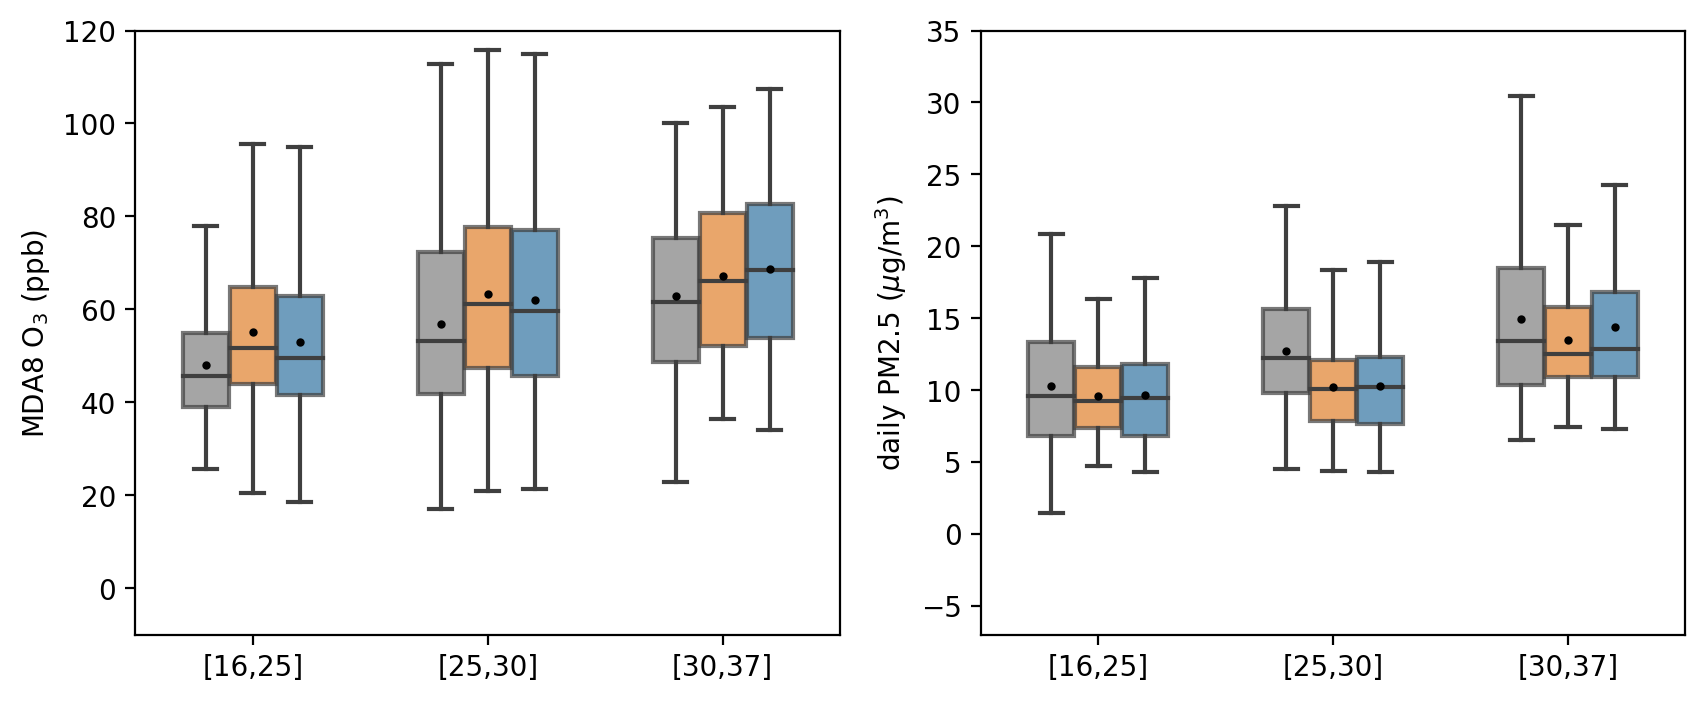

In [44]:
pair_obs = ['OZONE','PM2.5']
pair_wrf = ['o3','PM2_5_DRY']
pair_model = ['O3','PM2.5']

conc_df = pd.DataFrame()
this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = mdas[0].loc[:,pair_obs[i]].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'temp_bin_index'] = mdas[0].loc[:,'temp_bin_index']
this_df.loc[:,'longitude'] = mdas[0].reset_index().loc[:,'longitude']
conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = mdas[0].loc[:,pair_wrf[i]].values 
this_df.loc[:,'data_index'] = 1
this_df.loc[:,'temp_bin_index'] = mdas[0].loc[:,'temp_bin_index']
this_df.loc[:,'longitude'] = mdas[0].reset_index().loc[:,'longitude']

conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = mdas[1].loc[:,pair_wrf[i]].values
this_df.loc[:,'data_index'] = 2
this_df.loc[:,'temp_bin_index'] = mdas[1].loc[:,'temp_bin_index']
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = mdas[1].reset_index().loc[:,'longitude']

conc_df = pd.concat([conc_df, this_df])

fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=200)

#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='temp_bin_index',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"2"},
                     boxprops=dict(alpha=.7), ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
bplot.set(xticklabels=['[16,25]','[25,30]','[30,37]']) 
axs[0].set_ylabel('MDA8 O$_3$ (ppb)')
axs[0].set_ylim([-10,120])
axs[0].tick_params(axis='x', labelrotation = 0)

bplot = sns.boxplot(x='temp_bin_index',y='PM2.5', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"2"},
                     boxprops=dict(alpha=.7), ax=axs[1])
bplot.set(xticklabels=['[16,25]','[25,30]','[30,37]']) 
bplot.get_legend().remove()
bplot.set(xlabel=None)
axs[1].set_ylim([-7,35])
axs[1].set_ylabel('daily PM2.5 ($\mu$g/m$^{3}$)')
axs[1].tick_params(axis='x', labelrotation = 0)



Text(0.5, 1.0, 'WRF RACM2B-VCP')

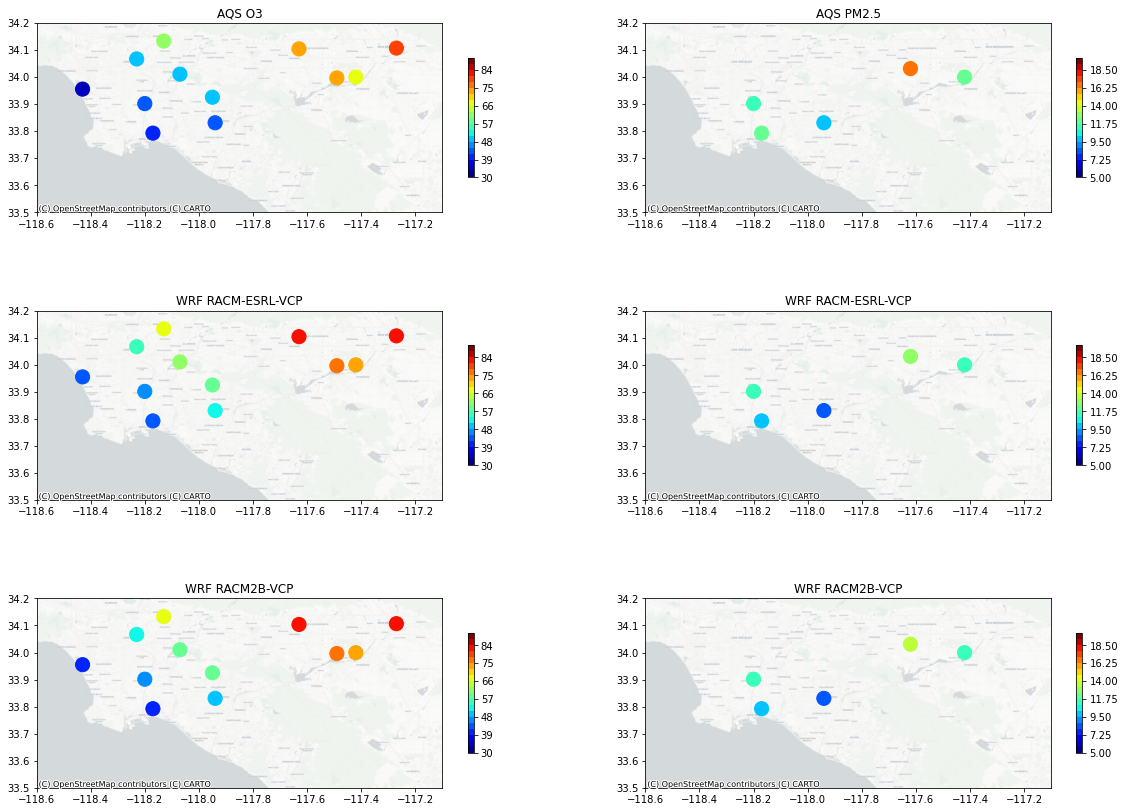

In [146]:
xlim =  [-118.6,-117.1] 
ylim = [33.5,34.2] 
space_avgs = []
for i in range(len(mdas)):
    mda = mdas[i]
    space_avg = mda.groupby(['longitude','latitude']).agg('mean').reset_index()
    space_avg = gpd.GeoDataFrame(
        space_avg, geometry=gpd.points_from_xy(space_avg['longitude'], space_avg['latitude']))
    space_avgs.append(space_avg)
    
#map
space_avg = space_avg.query('cls_indxs<5')
vmax = 90
vmin = 30

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap('jet',nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(20, 15))

#shapefile.plot(ax=axs[0,0], alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[0].plot(ax=axs[0,0], column = 'OZONE', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm)
axs[0,0].set_xlim(xlim)
axs[0,0].set_ylim(ylim)
cx.add_basemap(axs[0,0],source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[0,0].set_title('AQS O3',fontsize=12)

#shapefile.plot(ax=axs[1,0],alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[0].plot(ax=axs[1,0], column = 'o3', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, norm=norm)
axs[1,0].set_xlim(xlim)
axs[1,0].set_ylim(ylim)
cx.add_basemap(axs[1,0],source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[1,0].set_title('WRF RACM-ESRL-VCP',fontsize=12)

#shapefile.plot(ax=axs[2,0],alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[1].plot(ax=axs[2,0], column = 'o3', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, norm=norm)
axs[2,0].set_xlim(xlim)
axs[2,0].set_ylim(ylim)
cx.add_basemap(axs[2,0],source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[2,0].set_title('WRF RACM2B-VCP',fontsize=12)

vmax = 20
vmin = 5

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap('jet',nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


#shapefile.plot(ax=axs[0,1],alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[0].plot(ax=axs[0,1], column = 'PM2.5', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, norm=norm)
axs[0,1].set_xlim(xlim)
axs[0,1].set_ylim(ylim)
cx.add_basemap(axs[0,1],source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[0,1].set_title('AQS PM2.5',fontsize=12)

#shapefile.plot(ax=axs[1,1],alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[0].plot(ax=axs[1,1], column = 'PM2_5_DRY', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, norm=norm)
axs[1,1].set_xlim(xlim)
axs[1,1].set_ylim(ylim)
cx.add_basemap(axs[1,1],source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[1,1].set_title('WRF RACM-ESRL-VCP',fontsize=12)

#shapefile.plot(ax=axs[2,1],alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[1].plot(ax=axs[2,1], column = 'PM2_5_DRY', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, norm=norm)
axs[2,1].set_xlim(xlim)
axs[2,1].set_ylim(ylim)
cx.add_basemap(axs[2,1],source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[2,1].set_title('WRF RACM2B-VCP',fontsize=12)
#plt.legend()

In [ ]:
space_avgs[0][['longitude','latitude','OZONE','PM2.5']].to_csv('/Users/zhu/Dropbox/Publications/2023-RACM2B_VCP/Figures-v2/aqs_site_list.csv')


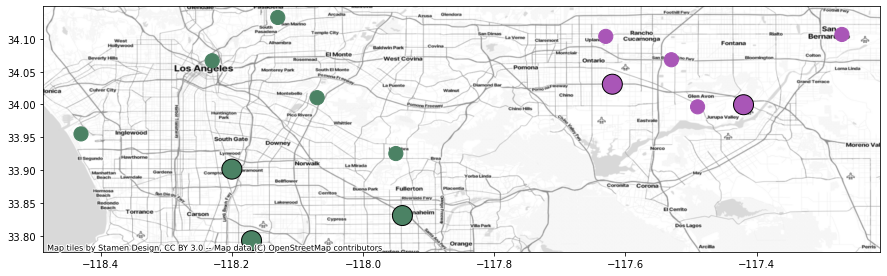

In [14]:
map_only = space_avgs[0]
indx = map_only.loc[:,'longitude']<=-117.8
map_only.loc[indx,'indx'] = 0
indx = map_only.loc[:,'longitude']>-117.8
map_only.loc[indx,'indx'] = 1

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(15, 10))
vmax = 1
vmin = 0

nlevels = 3
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap(sns.diverging_palette(145, 300, s=60, as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)
map_only.plot(ax=axs, column = 'indx' , cmap = cmap,
            markersize = 200, linewidth = 1,norm=norm )

map_only = space_avgs[0].dropna(subset='PM2.5')
map_only.plot(ax=axs, column = 'indx' , cmap = cmap,
            markersize = 400, linewidth = 1,norm=norm,edgecolor='k')
cx.add_basemap(axs,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)

plt.savefig('/Users/zhu/Dropbox/Publications/2023-RACM2B_VCP/Figures-v2/aqs_observations.pdf', format='pdf')


In [45]:
pair_obs = ['OZONE','PM2.5']
pair_wrf = ['o3','PM2_5_DRY']
pair_model = ['O3','PM2.5']


this_mda_weekdays = []
this_mda_weekends = []
this_mdas = []

for i in range(2):
    indx = mdas[i].loc[:,'weekday']<5
    this_mda_weekday = mdas[i].loc[indx,:].reset_index().groupby('longitude').mean().reset_index().sort_values(by='longitude')
    indx = mdas[i].loc[:,'weekday']>=5
    this_mda_weekend = mdas[i].loc[indx,:].reset_index().groupby('longitude').mean().reset_index().sort_values(by='longitude')
    this_mda = mdas[i].reset_index().groupby('longitude').mean().reset_index().sort_values(by='longitude')
    this_mda_weekdays.append(this_mda_weekday)
    this_mda_weekends.append(this_mda_weekend)
    this_mdas.append(this_mda)
    



Text(0.5, 1.0, 'WRF-Chem RACM2B-VCP')

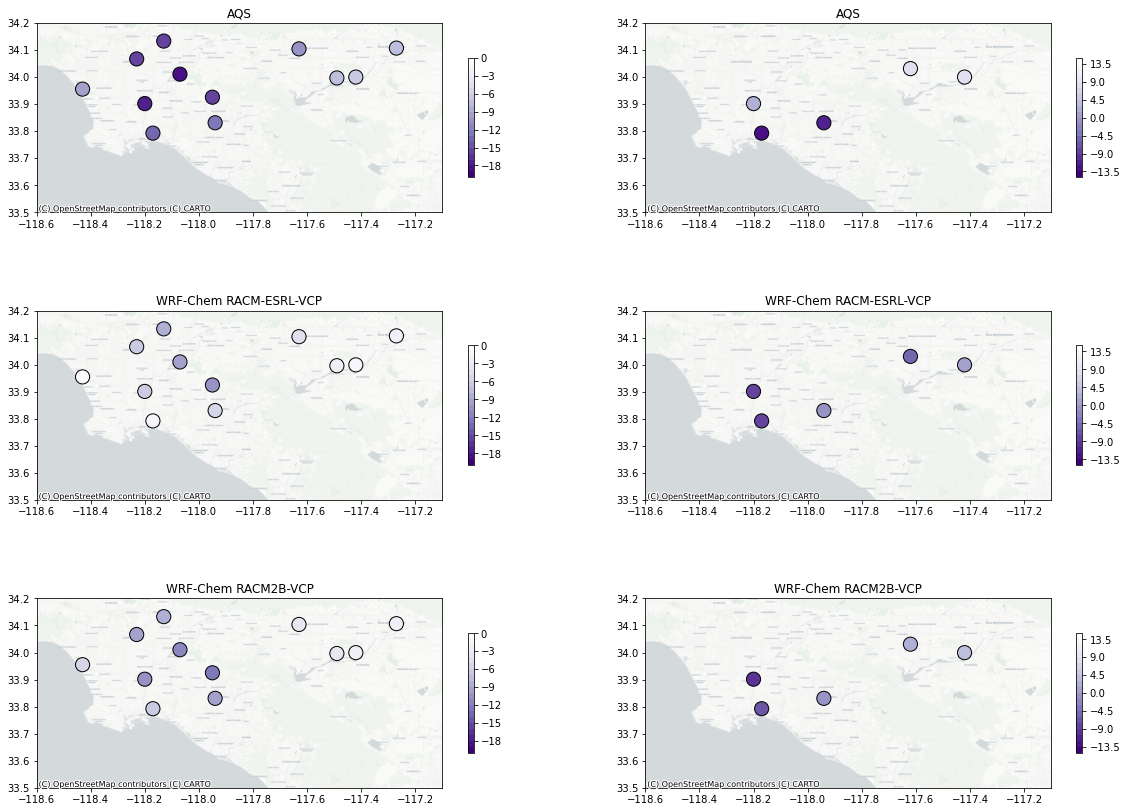

In [10]:
#map
xlim =  [-118.6,-117.1] 
ylim = [33.5,34.2] 
this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mda_weekdays[0].loc[:,pair_obs[i]].values-this_mda_weekends[0].loc[:,pair_obs[i]].values
    this_df.loc[:,pair_model[i]+'_value'] =this_mdas[0].loc[:,pair_obs[i]].values
    this_df.loc[:,pair_model[i]+'_ratio'] =this_df.loc[:,pair_model[i]]/this_df.loc[:,pair_model[i]+'_value']*100
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda_weekdays[0].reset_index().loc[:,'longitude']
this_df.loc[:,'latitude'] = this_mda_weekdays[0].reset_index().loc[:,'latitude']
this_df.loc[:,'cls_indxs'] = this_mda_weekdays[0].loc[:,'cls_indxs'].values

this_df = gpd.GeoDataFrame(
        this_df, geometry=gpd.points_from_xy(this_df['longitude'], this_df['latitude']))


vmax = 0
vmin = -20

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap(sns.color_palette("Purples_r", as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(20, 15))

#shapefile.plot(ax=axs[0,0], alpha = 0.2, cmap='RdBu', legend=True)
this_df.plot(ax=axs[0,0], column = 'O3_ratio', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm,edgecolor='k')
axs[0,0].set_xlim(xlim)
axs[0,0].set_ylim(ylim)
cx.add_basemap(axs[0,0], source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[0,0].set_title('AQS',fontsize=12)

clevel = np.linspace(-15,15,nlevels)
cmap = mpl.cm.get_cmap(sns.color_palette("Purples_r", as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)

#shapefile.plot(ax=axs[0,1], alpha = 0.2, cmap='RdBu', legend=True)
this_df.plot(ax=axs[0,1], column = 'PM2.5_ratio', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm,edgecolor='k')
axs[0,1].set_xlim(xlim)
axs[0,1].set_ylim(ylim)
cx.add_basemap(axs[0,1], source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[0,1].set_title('AQS',fontsize=12)


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mda_weekdays[0].loc[:,pair_wrf[i]].values-this_mda_weekends[1].loc[:,pair_wrf[i]].values
    this_df.loc[:,pair_model[i]+'_value'] =this_mdas[0].loc[:,pair_wrf[i]].values
    this_df.loc[:,pair_model[i]+'_ratio'] =this_df.loc[:,pair_model[i]]/this_df.loc[:,pair_model[i]+'_value']*100
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda_weekdays[0].reset_index().loc[:,'longitude']
this_df.loc[:,'latitude'] = this_mda_weekdays[0].reset_index().loc[:,'latitude']
this_df.loc[:,'cls_indxs'] = this_mda_weekdays[0].loc[:,'cls_indxs'].values

clevel = np.linspace(-20,0,nlevels)
cmap = mpl.cm.get_cmap(sns.color_palette("Purples_r", as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)

this_df = gpd.GeoDataFrame(
        this_df, geometry=gpd.points_from_xy(this_df['longitude'], this_df['latitude']))
#shapefile.plot(ax=axs[1,0], alpha = 0.2, cmap='RdBu', legend=True)

this_df.plot(ax=axs[1,0], column = 'O3_ratio', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm,edgecolor='k')
axs[1,0].set_xlim(xlim)
axs[1,0].set_ylim(ylim)
cx.add_basemap(axs[1,0], source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[1,0].set_title('WRF-Chem RACM-ESRL-VCP',fontsize=12)

clevel = np.linspace(-15,15,nlevels)
cmap = mpl.cm.get_cmap(sns.color_palette("Purples_r", as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)

this_df = gpd.GeoDataFrame(
        this_df, geometry=gpd.points_from_xy(this_df['longitude'], this_df['latitude']))
#shapefile.plot(ax=axs[1,1], alpha = 0.2, cmap='RdBu', legend=True)

this_df.plot(ax=axs[1,1], column = 'PM2.5_ratio', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm,edgecolor='k')
axs[1,1].set_xlim(xlim)
axs[1,1].set_ylim(ylim)
cx.add_basemap(axs[1,1], source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[1,1].set_title('WRF-Chem RACM-ESRL-VCP',fontsize=12)

this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mda_weekdays[1].loc[:,pair_wrf[i]].values-this_mda_weekends[1].loc[:,pair_wrf[i]].values
    this_df.loc[:,pair_model[i]+'_value'] =this_mdas[1].loc[:,pair_wrf[i]].values
    this_df.loc[:,pair_model[i]+'_ratio'] =this_df.loc[:,pair_model[i]]/this_df.loc[:,pair_model[i]+'_value']*100
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda_weekdays[1].reset_index().loc[:,'longitude']
this_df.loc[:,'latitude'] = this_mda_weekdays[1].reset_index().loc[:,'latitude']
this_df.loc[:,'cls_indxs'] = this_mda_weekdays[1].loc[:,'cls_indxs'].values

clevel = np.linspace(-20,0,nlevels)
cmap = mpl.cm.get_cmap(sns.color_palette("Purples_r", as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)

this_df = gpd.GeoDataFrame(
        this_df, geometry=gpd.points_from_xy(this_df['longitude'], this_df['latitude']))
#shapefile.plot(ax=axs[2,0], alpha = 0.2, cmap='RdBu', legend=True)

this_df.plot(ax=axs[2,0], column = 'O3_ratio', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm,edgecolor='k')
axs[2,0].set_xlim(xlim)
axs[2,0].set_ylim(ylim)
cx.add_basemap(axs[2,0], source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[2,0].set_title('WRF-Chem RACM2B-VCP',fontsize=12)

clevel = np.linspace(-15,15,nlevels)
cmap = mpl.cm.get_cmap(sns.color_palette("Purples_r", as_cmap=True),nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)

this_df = gpd.GeoDataFrame(
        this_df, geometry=gpd.points_from_xy(this_df['longitude'], this_df['latitude']))
#shapefile.plot(ax=axs[2,1], alpha = 0.2, cmap='RdBu', legend=True)

this_df.plot(ax=axs[2,1], column = 'PM2.5_ratio', cmap = cmap,
            legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 200, linewidth = 1,norm=norm,edgecolor='k')
axs[2,1].set_xlim(xlim)
axs[2,1].set_ylim(ylim)
cx.add_basemap(axs[2,1], source=cx.providers.CartoDB.Positron,crs='epsg:4326')
axs[2,1].set_title('WRF-Chem RACM2B-VCP',fontsize=12)


In [51]:
indx = this_mdas[0]['longitude'] <= -117.8
this_mdas[0].loc[indx,'area indx'] = 'West/Central LA'
indx = this_mdas[0]['longitude'] > -117.8
this_mdas[0].loc[indx,'area indx'] = 'East basin'
indx = this_mdas[1]['longitude'] <= -117.8
this_mdas[1].loc[indx,'area indx'] = 'West/Central LA'
indx = this_mdas[1]['longitude'] > -117.8
this_mdas[1].loc[indx,'area indx'] = 'East basin'
#this_mdas[0].droupby('area indx')[['OZONE','o3']].corr()**2

In [52]:
print(this_mdas[0].groupby('area indx')[['OZONE','o3']].corr()**2)
print(this_mdas[0].groupby('area indx')[['PM2_5_DRY','PM2.5']].corr()**2)
print(this_mdas[1].groupby('area indx')[['OZONE','o3']].corr()**2)
print(this_mdas[1].groupby('area indx')[['PM2_5_DRY','PM2.5']].corr()**2)

                          OZONE        o3
area indx                                
East basin      OZONE  1.000000  0.702509
                o3     0.702509  1.000000
West/Central LA OZONE  1.000000  0.855412
                o3     0.855412  1.000000
                           PM2_5_DRY     PM2.5
area indx                                     
East basin      PM2_5_DRY   1.000000  1.000000
                PM2.5       1.000000  1.000000
West/Central LA PM2_5_DRY   1.000000  0.543201
                PM2.5       0.543201  1.000000
                          OZONE        o3
area indx                                
East basin      OZONE  1.000000  0.620841
                o3     0.620841  1.000000
West/Central LA OZONE  1.000000  0.859806
                o3     0.859806  1.000000
                           PM2_5_DRY     PM2.5
area indx                                     
East basin      PM2_5_DRY   1.000000  1.000000
                PM2.5       1.000000  1.000000
West/Central LA PM2_5_DRY 

In [55]:
this_df = pd.DataFrame()
this_df.loc[:,'OZONE'] = (this_mda_weekdays[0].loc[:,'OZONE'].values-this_mda_weekends[1].loc[:,'OZONE'].values)/this_mdas[1].loc[:,'OZONE'].values
this_df.loc[:,'o3'] = (this_mda_weekdays[0].loc[:,'o3'].values-this_mda_weekends[1].loc[:,'o3'].values)/this_mdas[1].loc[:,'o3'].values
this_df.loc[:,'longitude'] = this_mda_weekdays[0].loc[:,'longitude']
indx = this_df['longitude'] <= -117.8
this_df.loc[indx,'area indx'] = 'West/Central LA'
indx = this_df['longitude'] > -117.8
this_df.loc[indx,'area indx'] = 'East basin'

this_df.groupby('area indx')[['OZONE','o3']].corr()**2


OZONE        o3
area indx                                
East basin      OZONE  1.000000  0.888565
                o3     0.888565  1.000000
West/Central LA OZONE  1.000000  0.564238
                o3     0.564238  1.000000

In [54]:
this_df = pd.DataFrame()
this_df.loc[:,'OZONE'] = (this_mda_weekdays[1].loc[:,'OZONE'].values-this_mda_weekends[1].loc[:,'OZONE'].values)/this_mdas[1].loc[:,'OZONE'].values
this_df.loc[:,'o3'] = (this_mda_weekdays[1].loc[:,'o3'].values-this_mda_weekends[1].loc[:,'o3'].values)/this_mdas[1].loc[:,'o3'].values
this_df.loc[:,'longitude'] = this_mda_weekdays[1].loc[:,'longitude']
indx = this_df['longitude'] <= -117.8
this_df.loc[indx,'area indx'] = 'West/Central LA'
indx = this_df['longitude'] > -117.8
this_df.loc[indx,'area indx'] = 'East basin'

this_df.groupby('area indx')[['OZONE','o3']].corr()**2


OZONE        o3
area indx                                
East basin      OZONE  1.000000  0.633470
                o3     0.633470  1.000000
West/Central LA OZONE  1.000000  0.568477
                o3     0.568477  1.000000

In [161]:
this_df = pd.DataFrame()
this_df.loc[:,'PM2_5_DRY'] = (this_mda_weekdays[0].loc[:,'PM2_5_DRY'].values-this_mda_weekends[0].loc[:,'PM2_5_DRY'].values)/this_mdas[0].loc[:,'PM2_5_DRY'].values
this_df.loc[:,'PM2.5'] = (this_mda_weekdays[0].loc[:,'PM2.5'].values-this_mda_weekends[0].loc[:,'PM2.5'].values)/this_mdas[0].loc[:,'PM2.5'].values

this_df[['PM2.5','PM2_5_DRY']].corr()**2


PM2.5  PM2_5_DRY
PM2.5      1.000000   0.303026
PM2_5_DRY  0.303026   1.000000

In [162]:
this_df = pd.DataFrame()
this_df.loc[:,'PM2_5_DRY'] = (this_mda_weekdays[1].loc[:,'PM2_5_DRY'].values-this_mda_weekends[1].loc[:,'PM2_5_DRY'].values)/this_mdas[1].loc[:,'PM2_5_DRY'].values
this_df.loc[:,'PM2.5'] = (this_mda_weekdays[1].loc[:,'PM2.5'].values-this_mda_weekends[1].loc[:,'PM2.5'].values)/this_mdas[1].loc[:,'PM2.5'].values

this_df[['PM2.5','PM2_5_DRY']].corr()**2

PM2.5  PM2_5_DRY
PM2.5      1.000000   0.205068
PM2_5_DRY  0.205068   1.000000

In [18]:
this_mdas[0]['temp_bin_index']

0     0.880597
1     0.880597
2     0.880597
3     0.880597
4     0.880597
5     0.880597
6     0.880597
7     0.880597
8     0.880597
9     0.880597
10    0.880597
11    0.880597
12    0.880597
13    0.880597
Name: temp_bin_index, dtype: float64

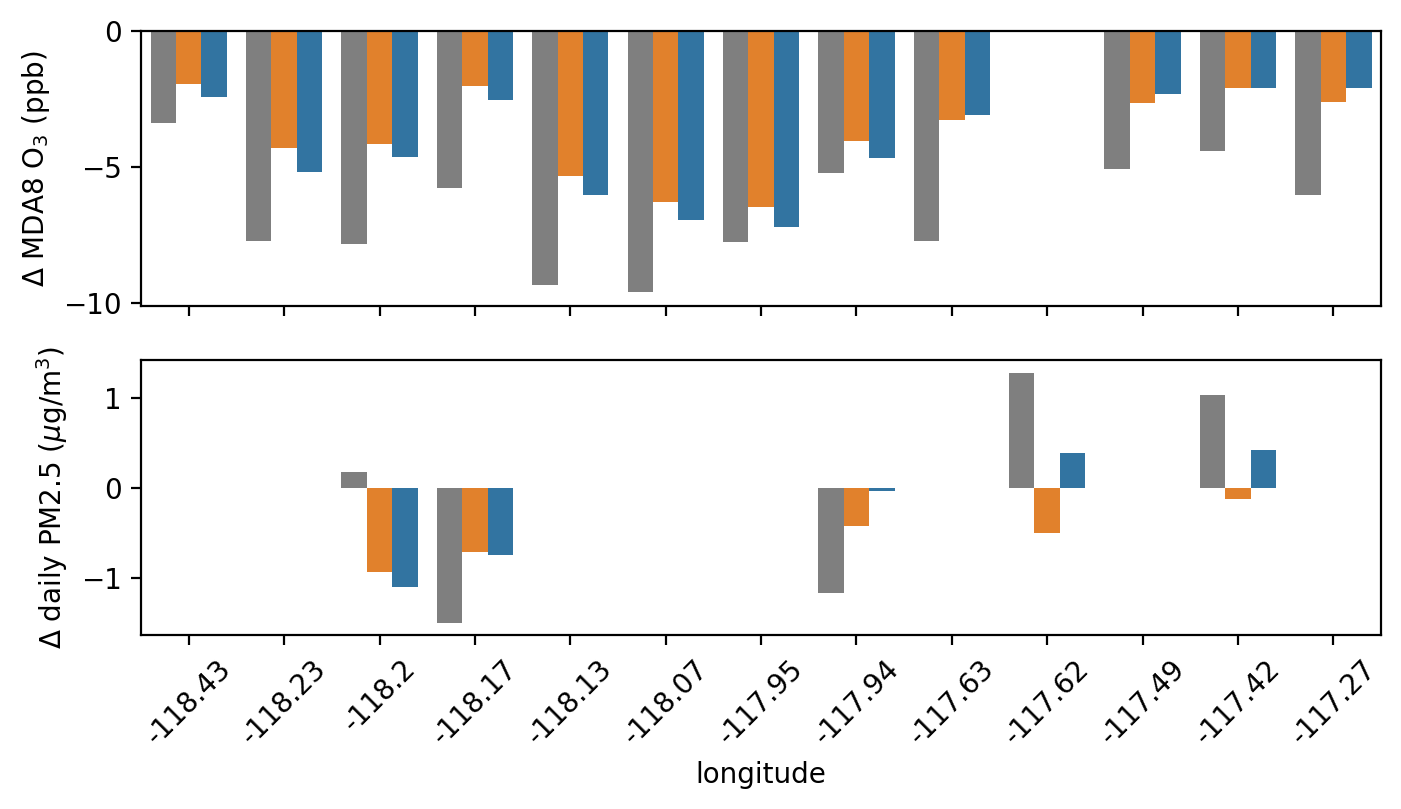

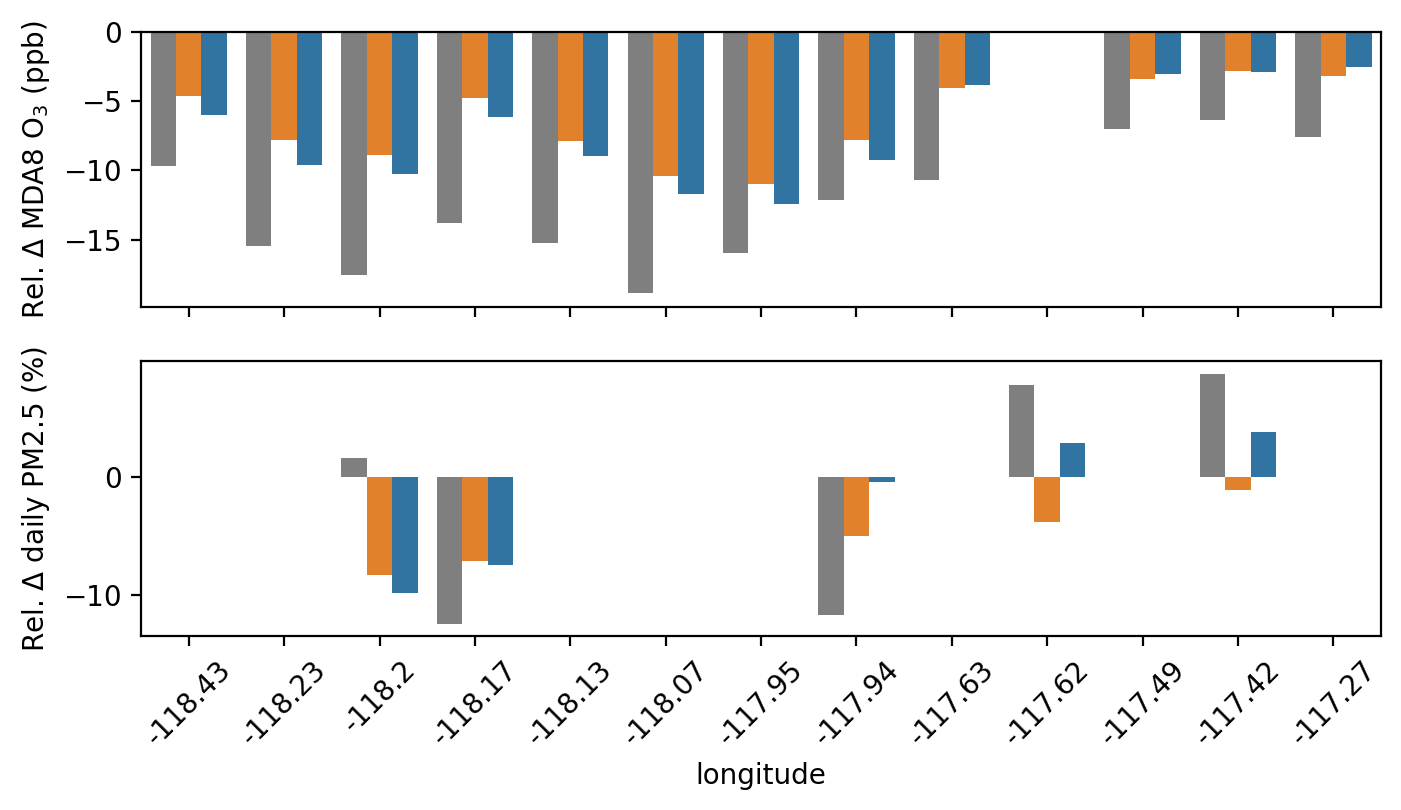

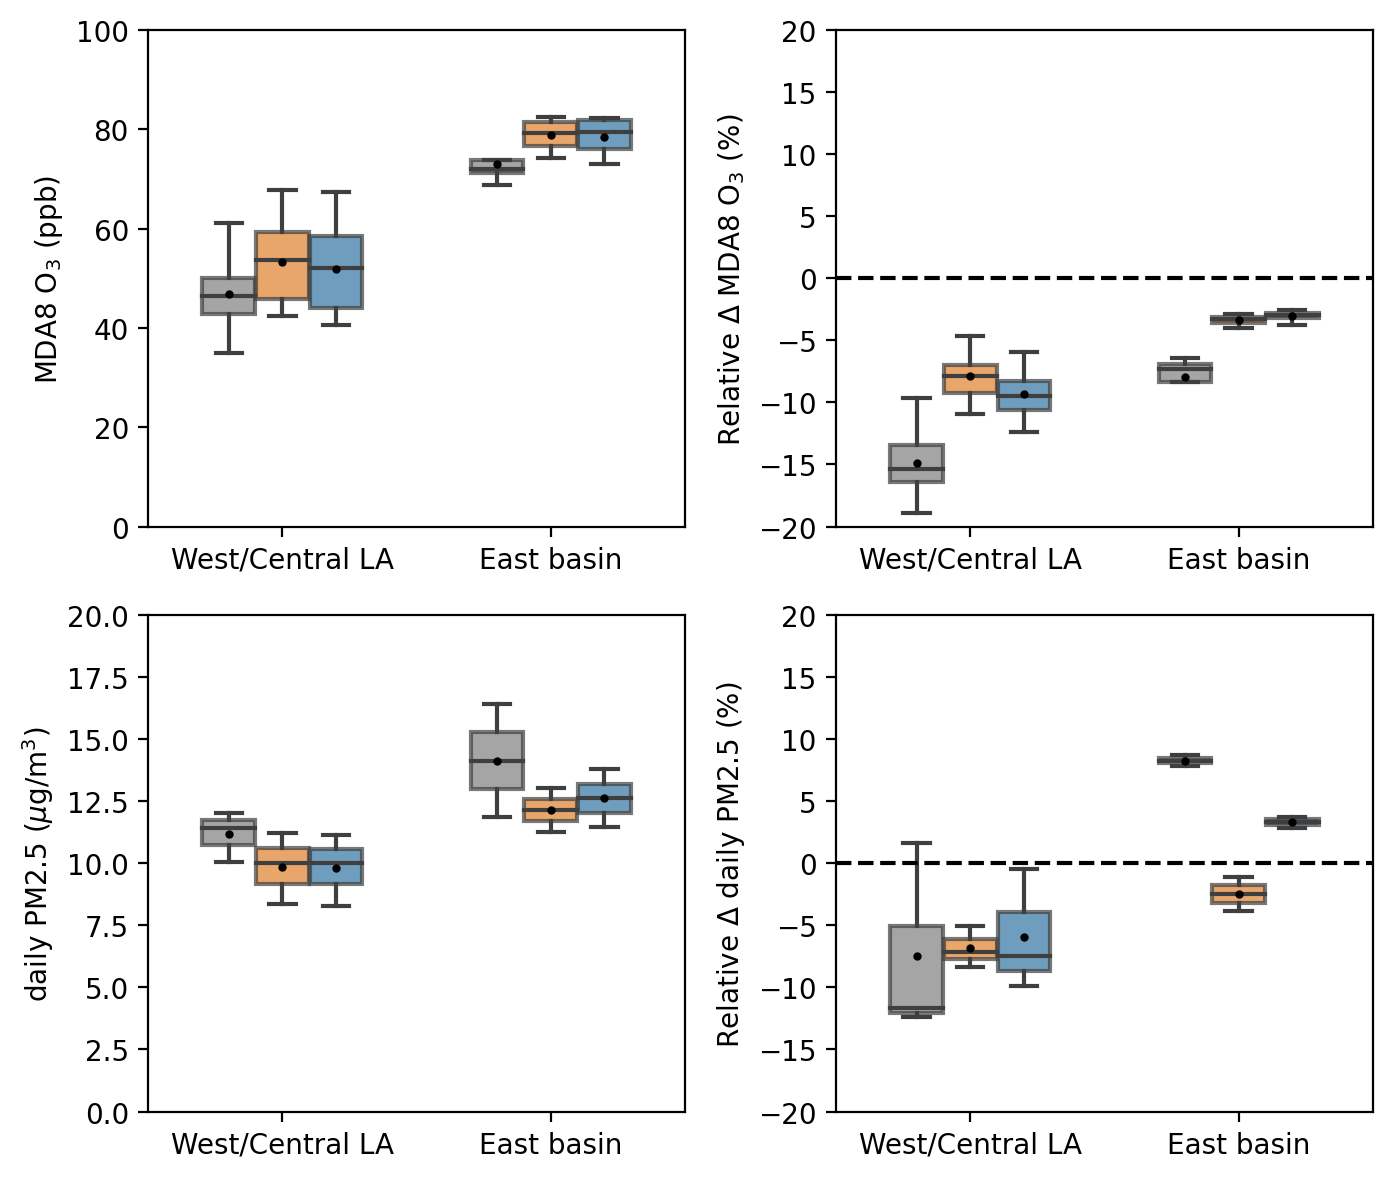

In [11]:
pair_obs = ['OZONE','PM2.5']
pair_wrf = ['o3','PM2_5_DRY']
pair_model = ['O3','PM2.5']


this_mda_weekdays = []
this_mda_weekends = []
this_mdas = []

for i in range(2):
    indx = mdas[i].loc[:,'weekday']<5
    this_mda_weekday = mdas[i].loc[indx,:].reset_index().groupby('longitude').mean().reset_index().sort_values(by='longitude')
    indx = mdas[i].loc[:,'weekday']>=5
    this_mda_weekend = mdas[i].loc[indx,:].reset_index().groupby('longitude').mean().reset_index().sort_values(by='longitude')
    this_mda = mdas[i].reset_index().groupby('longitude').mean().reset_index().sort_values(by='longitude')
    this_mda_weekdays.append(this_mda_weekday)
    this_mda_weekends.append(this_mda_weekend)
    this_mdas.append(this_mda)
    
conc_df = pd.DataFrame()
this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mda_weekdays[0].loc[:,pair_obs[i]].values-this_mda_weekends[0].loc[:,pair_obs[i]].values
    this_df.loc[:,pair_model[i]+'_value'] =this_mdas[0].loc[:,pair_obs[i]].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda_weekdays[0].reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekdays[0].loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mda_weekdays[0].loc[:,pair_wrf[i]].values - this_mda_weekends[0].loc[:,pair_wrf[i]].values
    this_df.loc[:,pair_model[i]+'_value'] =this_mdas[0].loc[:,pair_wrf[i]].values

this_df.loc[:,'data_index'] = 1
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = this_mda_weekdays[0].reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekdays[0].loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mda_weekdays[1].loc[:,pair_wrf[i]].values - this_mda_weekends[1].loc[:,pair_wrf[i]].values
    this_df.loc[:,pair_model[i]+'_value'] =this_mdas[1].loc[:,pair_wrf[i]].values
this_df.loc[:,'data_index'] = 2
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = this_mda_weekdays[1].reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekdays[1].loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])

box_colors = ['tab:gray','tab:orange','tab:blue']
conc_df = conc_df.query('cls_indxs<5')

indx = conc_df['longitude'] != -117.53
conc_df = conc_df.loc[indx,:]

indx = conc_df['longitude'] <= -117.8
conc_df.loc[indx,'area indx'] = 'West/Central LA'
indx = conc_df['longitude'] > -117.8
conc_df.loc[indx,'area indx'] = 'East basin'

#ratio
for i in range(2):
    conc_df.loc[:,pair_model[i]+'_ratio'] =conc_df.loc[:,pair_model[i]]/conc_df.loc[:,pair_model[i]+'_value']*100
    
ymaxs=[130]
ymins=[10]

i=0
fig, axs = plt.subplots(2,1,figsize=(8,4),dpi=200)

bplot = sns.barplot(x='longitude',y='O3', hue='data_index', data=conc_df, palette=box_colors, ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
bplot.set(xticklabels=[]) 
#axs.set_ylim([25,130])
axs[0].tick_params(axis='x', labelrotation = 45)
axs[0].set_ylabel('$\Delta$ MDA8 O$_3$ (ppb)')

bplot = sns.barplot(x='longitude',y='PM2.5', hue='data_index', data=conc_df, palette=box_colors, ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs[1].set_ylabel('$\Delta$ daily PM2.5 ($\mu$g/m$^{3}$)')
#axs.set_ylim([25,130])
axs[1].tick_params(axis='x', labelrotation = 45)

i=0
fig, axs = plt.subplots(2,1,figsize=(8,4),dpi=200)

bplot = sns.barplot(x='longitude',y='O3_ratio', hue='data_index', data=conc_df, palette=box_colors, ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
bplot.set(xticklabels=[]) 
#axs.set_ylim([25,130])
axs[0].tick_params(axis='x', labelrotation = 45)
axs[0].set_ylabel('Rel. $\Delta$ MDA8 O$_3$ (ppb)')

bplot = sns.barplot(x='longitude',y='PM2.5_ratio', hue='data_index', data=conc_df, palette=box_colors, ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs[1].set_ylabel('Rel. $\Delta$ daily PM2.5 (%)')
#axs.set_ylim([25,130])
axs[1].tick_params(axis='x', labelrotation = 45)


fig, axs = plt.subplots(2,2,figsize=(7,6),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='area indx',y='O3_value', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"2"},
                     boxprops=dict(alpha=.7), ax=axs[0,0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
#bplot.set(xticklabels=[]) 
axs[0,0].set_ylabel('MDA8 O$_3$ (ppb)')
axs[0,0].set_ylim([0,100])
axs[0,0].tick_params(axis='x', labelrotation = 0)

bplot = sns.boxplot(x='area indx',y='PM2.5_value', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"2"},
                     boxprops=dict(alpha=.7), ax=axs[1,0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
axs[1,0].set_ylim([0,20])
axs[1,0].set_ylabel('daily PM2.5 ($\mu$g/m$^{3}$)')
axs[1,0].tick_params(axis='x', labelrotation = 0)

bplot = sns.boxplot(x='area indx',y='O3_ratio', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"2"},
                    boxprops=dict(alpha=.7), ax=axs[0,1])
sns.lineplot(x=[-0.5,1.5],y=[0,0],linestyle='--',color='k', ax=axs[0,1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
axs[0,1].set_ylim([-20,20])
axs[0,1].set_xlim([-0.5,1.5])
axs[0,1].set_ylabel('Relative $\Delta$ MDA8 O$_3$ (%)')
axs[0,1].tick_params(axis='x', labelrotation = 0)

bplot = sns.boxplot(x='area indx',y='PM2.5_ratio', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"2"},
                    boxprops=dict(alpha=.7), ax=axs[1,1])
sns.lineplot(x=[-0.5,1.5],y=[0,0],linestyle='--',color='k', ax=axs[1,1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
#plt.plot([-0,1],[0,0],linestyle='--',color='k')
bplot.set(xlabel=None)
axs[1,1].set_ylim([-20,20])
axs[1,1].set_xlim([-0.5,1.5])
axs[1,1].set_ylabel('Relative $\Delta$ daily PM2.5 (%)')
axs[1,1].tick_params(axis='x', labelrotation = 0)

plt.tight_layout()

O3   O3_value     PM2.5  PM2.5_value  data_index  weekday_index  \
0  -3.374041  34.865672       NaN          NaN           0              0   
1  -7.721217  49.830224       NaN          NaN           0              0   
2  -7.810992  44.509328  0.182607    11.421362           0              0   
3  -5.778509  41.847015 -1.495117    12.045178           0              0   
4  -9.336623  61.126866       NaN          NaN           0              0   
5  -9.609375  50.865672       NaN          NaN           0              0   
6  -7.751645  48.479477       NaN          NaN           0              0   
7  -5.221354  43.009328 -1.169236    10.031391           0              0   
8  -7.716831  72.037313       NaN          NaN           0              0   
9        NaN        NaN  1.284054    16.428355           0              0   
11 -5.068120  72.096082       NaN          NaN           0              0   
12 -4.397436  68.824074  1.033224    11.846557           0              0   
13 -6.014474  78.935547       NaN          NaN           0              0   
0  -1.961354  42.436780       NaN          NaN           1              0   
1  -4.316016  55.082330       NaN          NaN           1              0   
2  -4.144772  46.742601 -0.934284    11.230328           1              0   
3  -2.031826  42.704504 -0.714122    10.012182           1              0   
4  -5.332521  67.799211       NaN          NaN           1              0   
5  -6.295889  60.376174       NaN          NaN           1              0   
6  -6.470205  59.035732       NaN          NaN           1              0   
7  -4.052376  52.123251 -0.420803     8.349637           1              0   
8  -3.278027  81.126345       NaN          NaN           1              0   
9        NaN        NaN -0.502602    13.038234           1              0   
11 -2.649614  77.423639       NaN          NaN           1              0   
12 -2.113547  74.227836 -0.123599    11.242076           1              0   
13 -2.608700  82.482899       NaN          NaN           1              0   
0  -2.417768  40.494175       NaN          NaN           2              0   
1  -5.173445  53.642561       NaN          NaN           2              0   
2  -4.631967  45.129428 -1.100792    11.157246           2              0   
3  -2.518691  40.833322 -0.746212    10.024273           2              0   
4  -6.027351  67.429219       NaN          NaN           2              0   
5  -6.963279  59.428213       NaN          NaN           2              0   
6  -7.211995  58.097404       NaN          NaN           2              0   
7  -4.671589  50.530052 -0.035970     8.281473           2              0   
8  -3.105227  81.675692       NaN          NaN           2              0   
9        NaN        NaN  0.393275    13.789170           2              0   
11 -2.329476  77.129068       NaN          NaN           2              0   
12 -2.112260  73.016186  0.431126    11.441415           2              0   
13 -2.089701  82.319006       NaN          NaN           2              0   

    con_index  longitude  cls_indxs        area indx   O3_ratio  PM2.5_ratio  
0           0    -118.43        3.0  West/Central LA  -9.677257          NaN  
1           0    -118.23        0.0  West/Central LA -15.495048          NaN  
2           0    -118.20        0.0  West/Central LA -17.549113     1.598821  
3           0    -118.17        3.0  West/Central LA -13.808652   -12.412581  
4           0    -118.13        1.0  West/Central LA -15.274172          NaN  
5           0    -118.07        0.0  West/Central LA -18.891670          NaN  
6           0    -117.95        2.0  West/Central LA -15.989539          NaN  
7           0    -117.94        2.0  West/Central LA -12.140050   -11.655774  
8           0    -117.63        1.0       East basin -10.712269          NaN  
9           0    -117.62        1.0       East basin        NaN     7.816084  
11          0    -117.49        1.0       East basin  -7.029

In [174]:
conc_df.groupby(['area indx','data_index']).agg(['mean','median','min','max'])

O3                                 \
                                mean    median        min       max   
area indx       data_index                                            
East basin      0          -3.291135 -3.102059  -4.922664 -2.037757   
                1          -0.989227 -1.145825  -2.120141  0.454883   
                2          -0.806655 -0.840541  -1.997717  0.452179   
West/Central LA 0          -7.979424 -8.568072 -10.764366 -3.509130   
                1          -4.811441 -4.652797  -7.961804 -1.137399   
                2          -5.509788 -5.430677  -8.681610 -1.518064   

                             O3_value                                   \
                                 mean     median        min        max   
area indx       data_index                                               
East basin      0           83.889355  84.027573  77.352273  90.150000   
                1           88.479956  90.382288  82.255220  90.900029   
                2           89.021064  91.132798  81.664120  92.154540   
West/Central LA 0           51.880055  51.424632  36.977941  69.007353   
                1           59.153491  59.400071  44.868712  78.205183   
                2           58.018455  58.171262  42.773675  78.164846   

                               PM2.5            ... cls_indxs       O3_ratio  \
                                mean    median  ...       min  max      mean   
area indx       data_index                      ...                            
East basin      0           1.242576  1.242576  ...       1.0  1.0 -0.039365   
                1          -0.280421 -0.280421  ...       1.0  1.0 -0.010784   
                2           0.434577  0.434577  ...       1.0  1.0 -0.008615   
West/Central LA 0          -0.763108 -1.126919  ...       0.0  3.0 -0.150697   
                1          -0.671600 -0.681323  ...       0.0  3.0 -0.077845   
                2          -0.623031 -0.716084  ...       0.0  3.0 -0.091622   

                                                         PM2.5_ratio  \
                              median       min       max        mean   
area indx       data_index                                             
East basin      0          -0.037522 -0.059813 -0.022604    0.088527   
                1          -0.012615 -0.023435  0.005530   -0.021966   
                2          -0.009108 -0.021782  0.005537    0.034912   
West/Central LA 0          -0.159181 -0.184650 -0.094898   -0.068980   
                1          -0.081781 -0.115662 -0.025349   -0.066422   
                2          -0.093558 -0.126719 -0.035491   -0.058991   

                                                          
                              median       min       max  
area indx       data_index                                
East basin      0           0.088527  0.082023  0.095031  
                1          -0.021966 -0.036887 -0.007044  
                2           0.034912  0.029149  0.040676  
West/Central LA 0          -0.112053 -0.115210  0.020325  
                1          -0.067910 -0.081937 -0.049419  
                2          -0.071978 -0.098662 -0.006334  

[6 rows x 40 columns]

In [173]:
print()

O3   O3_value     PM2.5  PM2.5_value  data_index  weekday_index  \
0   -3.509130  36.977941       NaN          NaN           0              0   
1   -8.986574  55.294118       NaN          NaN           0              0   
2   -8.226369  48.716912  0.232894    11.458701           0              0   
3   -6.792293  45.737132 -1.395298    12.110872           0              0   
4  -10.754028  69.007353       NaN          NaN           0              0   
5  -10.764366  58.295956       NaN          NaN           0              0   
6   -8.909774  54.132353       NaN          NaN           0              0   
7   -5.892857  46.878676 -1.126919    10.057008           0              0   
8   -4.922664  82.301470       NaN          NaN           0              0   
9         NaN        NaN  1.351956    16.482639           0              0   
11  -4.075994  85.753676       NaN          NaN           0              0   
12  -2.128125  77.352273  1.133196    11.924482           0              0   
13  -2.037757  90.150000       NaN          NaN           0              0   
0   -1.137399  44.868712       NaN          NaN           1              0   
1   -4.570890  62.219146       NaN          NaN           1              0   
2   -4.533116  51.137982 -0.920651    11.236104           1              0   
3   -2.119345  46.110514 -0.681323    10.032778           1              0   
4   -6.247207  78.205183       NaN          NaN           1              0   
5   -7.961804  68.836809       NaN          NaN           1              0   
6   -7.187069  65.268588       NaN          NaN           1              0   
7   -4.734703  56.580996 -0.412825     8.353535           1              0   
8   -2.120141  90.467873       NaN          NaN           1              0   
9         NaN        NaN -0.481424    13.051346           1              0   
11  -2.032078  90.900029       NaN          NaN           1              0   
12   0.454883  82.255220 -0.079418    11.273853           1              0   
13  -0.259572  90.296704       NaN          NaN           1              0   
0   -1.518064  42.773675       NaN          NaN           2              0   
1   -5.473371  61.242710       NaN          NaN           2              0   
2   -5.387982  49.543212 -1.100792    11.157246           2              0   
3   -2.841939  44.063719 -0.716084     9.948637           2              0   
4   -6.797187  78.164846       NaN          NaN           2              0   
5   -8.681610  68.510632       NaN          NaN           2              0   
6   -7.992466  64.749033       NaN          NaN           2              0   
7   -5.385684  55.099814 -0.052218     8.243963           2              0   
8   -1.997717  91.713741       NaN          NaN           2              0   
9         NaN        NaN  0.401475    13.773399           2              0   
11  -1.820701  92.154540       NaN          NaN           2              0   
12   0.452179  81.664120  0.467679    11.497771           2              0   
13   0.139619  90.551855       NaN          NaN           2              0   

    con_index  longitude  cls_indxs        area indx  O3_ratio  PM2.5_ratio  
0           0    -118.43        3.0  West/Central LA -0.094898          NaN  
1           0    -118.23        0.0  West/Central LA -0.162523          NaN  
2           0    -118.20        0.0  West/Central LA -0.168861     0.020325  
3           0    -118.17        3.0  West/Central LA -0.148507    -0.115210  
4           0    -118.13        1.0  West/Central LA -0.155839          NaN  
5           0    -118.07        0.0  West/Central LA -0.184650          NaN  
6           0    -117.95        2.0  West/Central LA -0.164592          NaN  
7           0    -117.94        2.0  West/Central LA -0.125704    -0.112053  
8           0    -117.63        1.0       East basin -0.059813          NaN  
9           0    -117.62        1.0       East basin       NaN     0.082023  
11          0    -117.49        

In [167]:
print(12.406740-10.789523)
print(12.406740-10.924203)
print(10.789523/12.406740-1)
print(10.924203/12.406740-1)

1.6172169999999984
1.4825369999999989
-0.13034987434249434
-0.11949448444958133


In [168]:
print(68.928980-62.549822)
print(68.928980/62.549822-1)

6.379157999999997
0.10198523026971995


In [169]:
print(68.352658-62.549822)
print(68.352658/62.549822-1)

5.802836000000006
0.09277142307455333


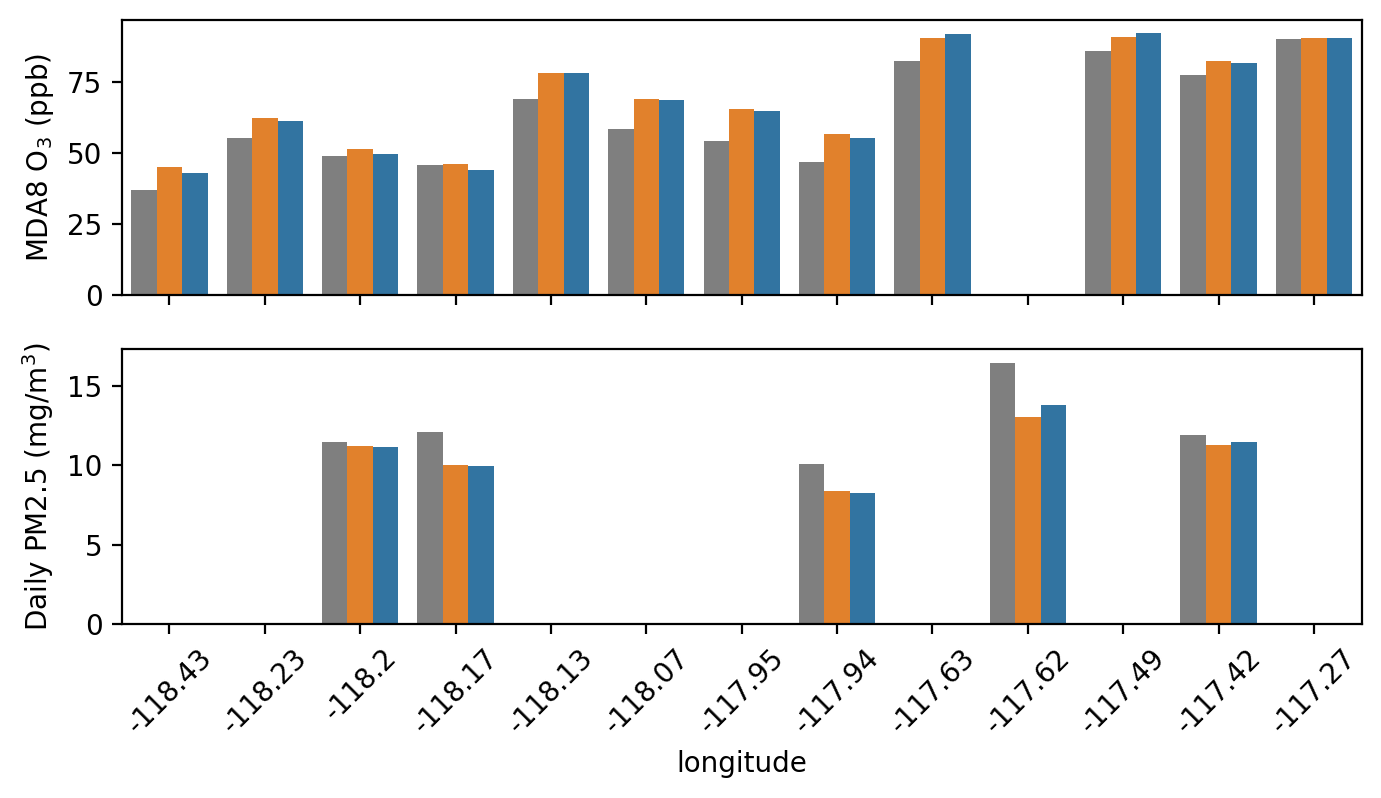

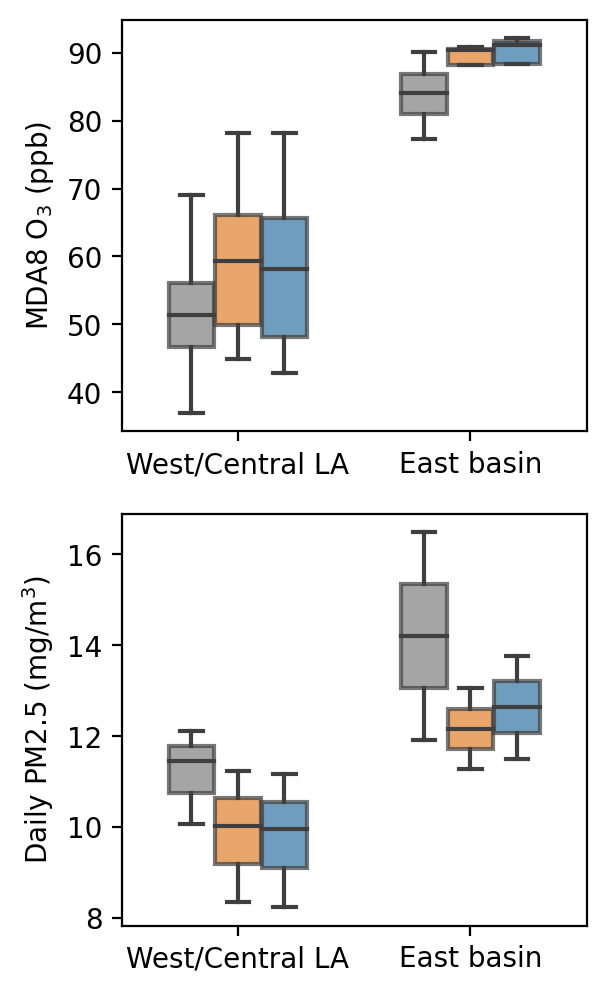

In [109]:
conc_df = pd.DataFrame()
this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mdas[0].loc[:,pair_obs[i]].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda_weekdays[0].reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekdays[0].loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mdas[0].loc[:,pair_wrf[i]].values 
this_df.loc[:,'data_index'] = 1
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = this_mda_weekdays[0].reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekdays[0].loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
for i in range(2):
    this_df.loc[:,pair_model[i]] = this_mdas[1].loc[:,pair_wrf[i]].values
this_df.loc[:,'data_index'] = 2
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = this_mda_weekdays[1].reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekdays[1].loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])

box_colors = ['tab:gray','tab:orange','tab:blue']
conc_df = conc_df.query('cls_indxs<5')

indx = conc_df['longitude'] != -117.53
conc_df = conc_df.loc[indx,:]

indx = conc_df['longitude'] <= -117.8
conc_df.loc[indx,'area indx'] = 'West/Central LA'
indx = conc_df['longitude'] > -117.8
conc_df.loc[indx,'area indx'] = 'East basin'


ymaxs=[130]
ymins=[10]

i=0
fig, axs = plt.subplots(2,1,figsize=(8,4),dpi=200)

bplot = sns.barplot(x='longitude',y='O3', hue='data_index', data=conc_df, palette=box_colors, ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
bplot.set(xticklabels=[]) 
#axs.set_ylim([25,130])
axs[0].tick_params(axis='x', labelrotation = 45)
axs[0].set_ylabel('MDA8 O$_3$ (ppb)')

bplot = sns.barplot(x='longitude',y='PM2.5', hue='data_index', data=conc_df, palette=box_colors, ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs[1].set_ylabel('Daily PM2.5 (mg/m$^{3}$)')
#axs.set_ylim([25,130])
axs[1].tick_params(axis='x', labelrotation = 45)

fig, axs = plt.subplots(2,1,figsize=(3,6),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='area indx',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
#bplot.set(xticklabels=[]) 
axs[0].set_ylabel('MDA8 O$_3$ (ppb)')
axs[0].tick_params(axis='x', labelrotation = 0)

bplot = sns.boxplot(x='area indx',y='PM2.5', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
axs[1].set_ylabel('Daily PM2.5 (mg/m$^{3}$)')
axs[1].tick_params(axis='x', labelrotation = 0)

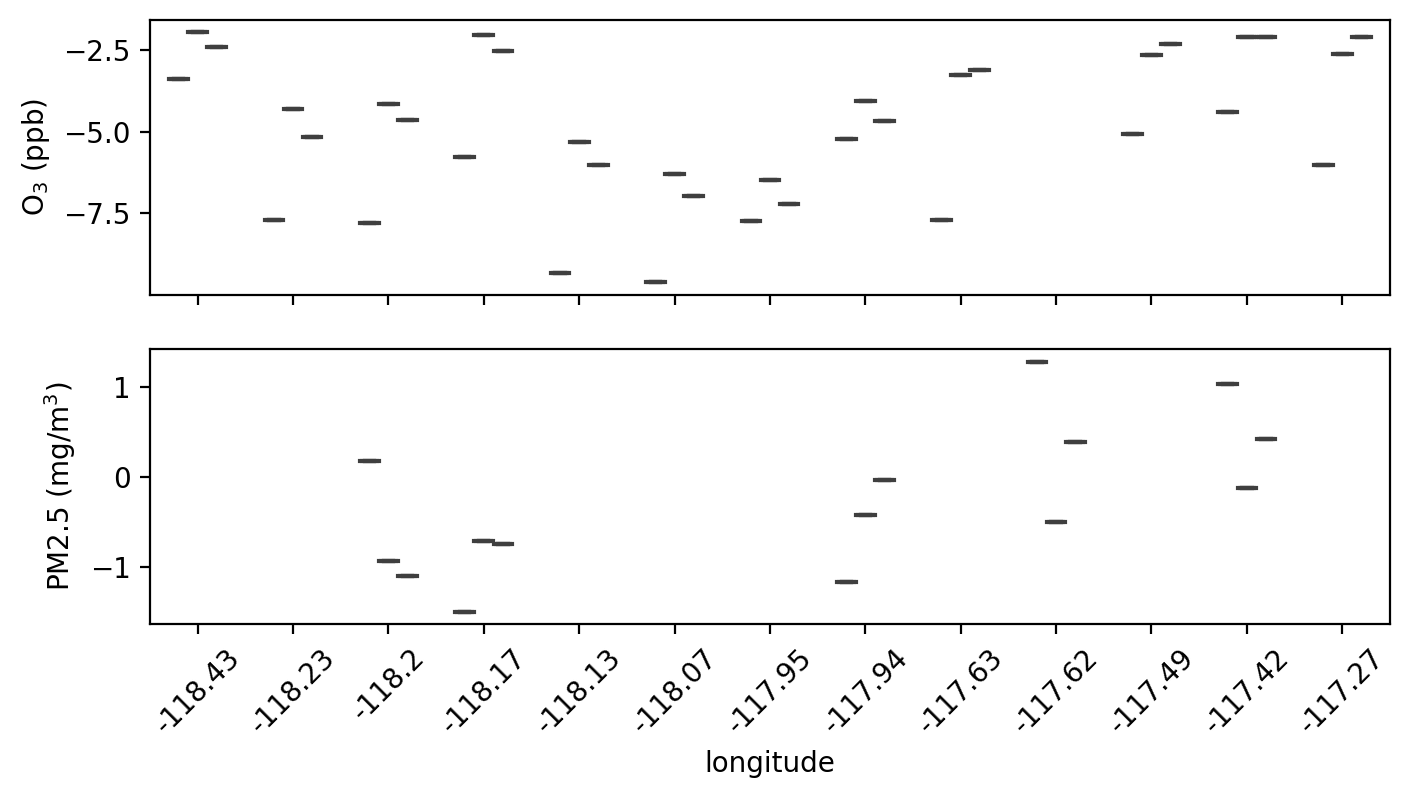

In [12]:
indx = conc_df['longitude'] != -117.53
conc_df = conc_df.loc[indx,:]
box_colors = ['tab:gray','tab:orange','tab:blue']
conc_df = conc_df.query('cls_indxs<5')

fig, axs = plt.subplots(2,1,figsize=(8,4),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='longitude',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
bplot.set(xticklabels=[]) 
axs[0].set_ylabel('O$_3$ (ppb)')
#axs[0].tick_params(axis='x', labelrotation = 45)

bplot = sns.boxplot(x='longitude',y='PM2.5', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs[1].set_ylabel('PM2.5 (mg/m$^{3}$)')
axs[1].tick_params(axis='x', labelrotation = 45)

ValueError: Could not interpret input 'temp_bin_index'

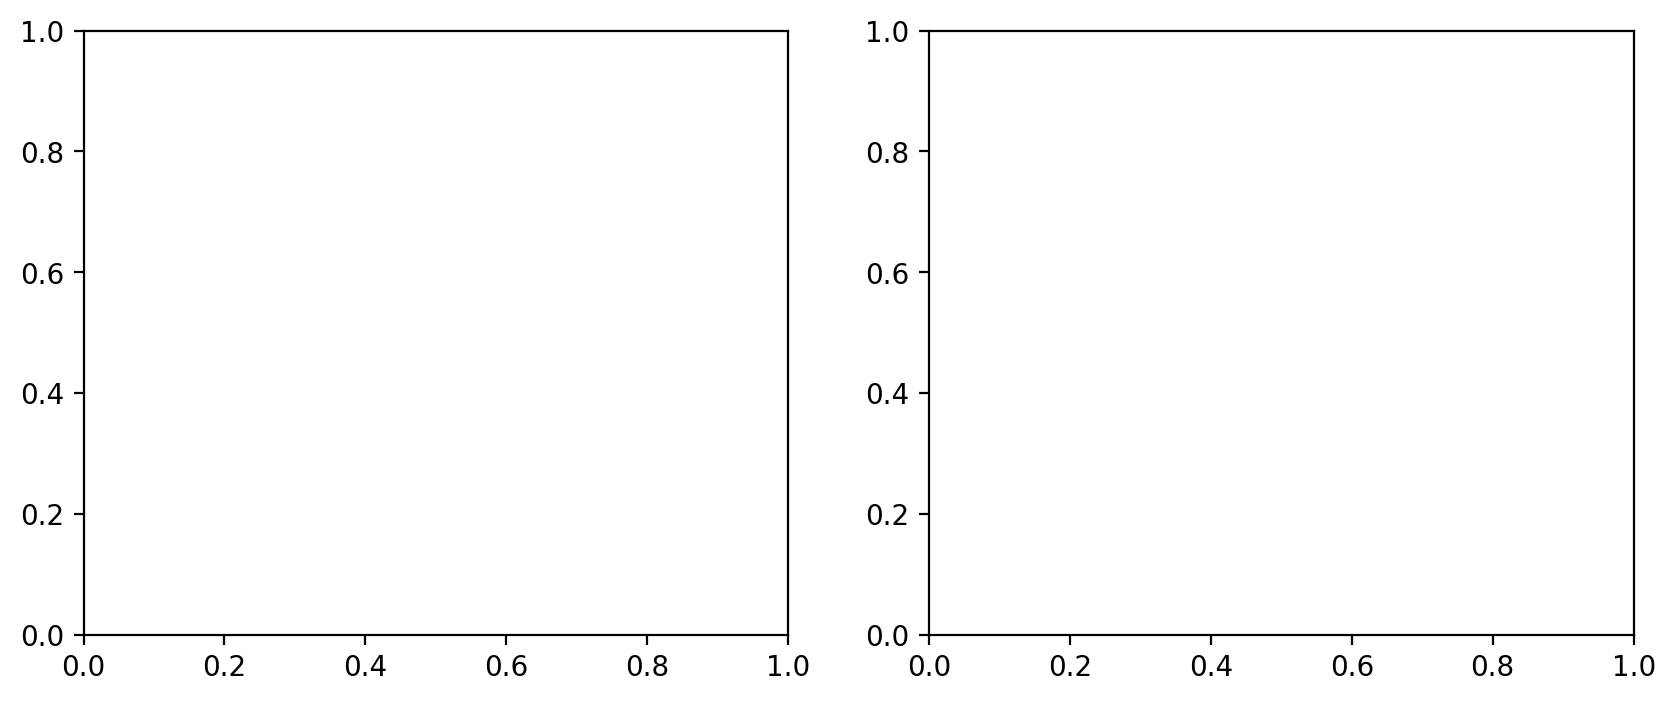

In [13]:
box_colors = ['tab:gray','tab:blue']
conc_df = conc_df.query('cls_indxs<5')

box_colors = ['tab:gray','tab:orange','tab:blue']
fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='temp_bin_index',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"3"},
                    boxprops=dict(alpha=.7), ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
med_temp = conc_df.groupby('temp_bin_index').mean().reset_index()
#axs[0].set_xticks(med_temp['temp_bin_index'], (np.rint(med_temp['temp']+273)).astype(int), fontsize=10,rotation=0)
axs[0].set_xticks(med_temp['temp_bin_index'],['[16,25]','[25,30]','[30,37]'], fontsize=10,rotation=0)
axs[0].set_ylabel('MDA8 O$_3$ (ppb)')

#bplot.set(xticklabels=[]) 
#axs[0].tick_params(axis='x', labelrotation = 45)

bplot = sns.boxplot(x='temp_bin_index',y='PM2.5', hue='data_index', data=conc_df, showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"3"}, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[1])
bplot.get_legend().remove()
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
med_temp = conc_df.groupby('temp_bin_index').mean().reset_index()
#axs[1].set_xticks(med_temp['temp_bin_index'], (np.rint(med_temp['temp']+273)).astype(int), fontsize=10,rotation=0)
axs[1].set_xticks(med_temp['temp_bin_index'],['[16,25]','[25,30]','[30,37]'], fontsize=10,rotation=0)

axs[1].set_ylabel('Daily PM2.5 (mg/m$^{3}$)')
axs[1].tick_params(axis='x', labelrotation = 0)
axs[1].set_xlabel('')

In [ ]:

indx = conc_df['longitude'] <= -117.8
conc_df.loc[indx,'area indx'] = 'West/Central LA'
indx = conc_df['longitude'] > -117.8
conc_df.loc[indx,'area indx'] = 'East basin'

fig, axs = plt.subplots(2,1,figsize=(4,6),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='area indx',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
#bplot.set(xticklabels=[]) 
axs[0].set_ylabel('O$_3$ (ppb)')
axs[0].tick_params(axis='x', labelrotation = 0)

bplot = sns.boxplot(x='area indx',y='PM2.5', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
axs[1].set_ylabel('PM2.5 (mg/m$^{3}$)')
axs[1].tick_params(axis='x', labelrotation = 0)

In [21]:

for i in range(len(df_wrfs)):
    print(i)
    #idx = (df_wrfs[i]['latitude'] <= 34.2) & (df_wrfs[i]['latitude'] >= 33.6) & (df_wrfs[i]['longitude'] >= -118.82) & (df_wrfs[i]['longitude'] <= -117)
    #print(sum(idx))
    df_wrfs[i]['OZONE'] = df_wrfs[i]['OZONE']*1e3
    #df_wrfs[i] = df_wrfs[i].loc[idx, :]


0
18432736


0


In [6]:
#recap_days = [1,4,6,10,11,12,18,19,21]
for i in range(len(wrf_files)):
    #gdfs[i]['hour'] = pd.to_datetime(gdfs[0]['time_local']).dt.hour
    #gdfs[i]['month'] = pd.to_datetime(gdfs[0]['time_local']).dt.month
    #gdfs[i]['day'] = pd.to_datetime(gdfs[0]['time_local']).dt.day
    gdfs[i]['hour'] = pd.to_datetime(gdfs[i]['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.hour
    gdfs[i]['month'] = pd.to_datetime(gdfs[i]['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.month
    gdfs[i]['date'] = pd.to_datetime(gdfs[i]['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.date
    #index = (gdfs[i]['hour']>=13) &  (gdfs[i]['hour']<=17)
    #gdfs[i] = gdfs[i][index]
    
    gdfs[i] = gdfs[i].reset_index()


KeyError: 'time'

In [7]:
print(np.sort(gdfs[0].query('cls_indxs<5')['longitude'].unique()))


[-118.43046  -118.226755 -118.205    -118.200707 -118.175278 -118.171019
 -118.127142 -118.068484 -117.952586 -117.938509 -117.923963 -117.918759
 -117.7506   -117.629096 -117.617403 -117.525796 -117.4925   -117.491982
 -117.415831 -117.274063]


In [23]:

print(np.sort(gdfs[0].query('cls_indxs<5')['longitude'].unique()))

scale = ['Neighbor','Neighbor','Middle','Neighbor','Middle','Neighbor',
         'Neighbor','Urban','Micro','Micro','Urban','Neighbor',
         'Urban','Neighbor','Neighbor']

[-118.43049  -118.22688  -118.205    -118.200707 -118.17533  -118.171019
 -118.1272   -118.0685   -117.95264  -117.93845  -117.92391  -117.918759
 -117.7514   -117.62914  -117.61722  -117.52579  -117.4924   -117.49201
 -117.41601  -117.274063]


In [ ]:

mda = pd.DataFrame()

lons = np.sort(gdfs[0].query('cls_indxs<5')['longitude'].unique())

n=0
for i, lon in enumerate(lons):
    for day in recap_days:

        indx = (gdfs[0]['day'] == day) & (gdfs[0]['longitude'] == lon) 
        if len(gdfs[0].loc[indx,'latitude'].values)>0:
            mda.loc[n, 'OZONE'] = gdfs[0].loc[indx,:].sort_values(by='OZONE', ascending=False)['OZONE'][:8].mean()
            mda.loc[n, 'o3'] = gdfs[0].loc[indx,:].sort_values(by='o3', ascending=False)['o3'][:8].mean()
            
            mda.loc[n, 'PM2_5_DRY'] = gdfs[0].loc[indx,:].sort_values(by='OZONE', ascending=False)['PM2_5_DRY'][:8].mean()
            mda.loc[n, 'PM2.5'] = gdfs[0].loc[indx,:].sort_values(by='o3', ascending=False)['PM2.5'][:8].mean()
            
            mda.loc[n, 'TEMP'] = gdfs[0].loc[indx,:].sort_values(by='o3', ascending=False)['TEMP'][:8].mean()
            #print(gdfs[0].loc[indx,:].sort_values(by='OZONE', ascending=False)[['time_local','OZONE']])
            mda.loc[n, 'latitude'] = gdfs[0].loc[indx,'latitude'].values[0]
            mda.loc[n, 'longitude'] = lon
            mda.loc[n, 'day'] = day
            mda.loc[n, 'weekday'] = gdfs[0].loc[indx,'weekday'].values[0]
            #mda.loc[n, 'scale'] = scale[i]
            n = n+1
            
indx = (mda.loc[:, 'longitude'] <= -117.93) | (mda.loc[:, 'longitude'] >= -117.7)
mda = mda.loc[indx,:]



In [168]:
mda[mda['longitude']==lons[0]]

OZONE         o3  PM2_5_DRY  PM2.5    TEMP  latitude  longitude   day  \
0   37.375  48.661186  11.639316    NaN -274.16  33.95507 -118.43049   1.0   
1   39.000  45.021793   9.376260    NaN -274.16  33.95507 -118.43049   2.0   
2   42.500  42.269978   8.109531    NaN -274.16  33.95507 -118.43049   3.0   
3   38.750  36.308094   7.270568    NaN -274.16  33.95507 -118.43049   4.0   
4   35.875  35.662441   6.147014    NaN -274.16  33.95507 -118.43049   5.0   
5   35.875  36.032917   6.228732    NaN -274.16  33.95507 -118.43049   6.0   
6   38.500  38.639229   3.860491    NaN -274.16  33.95507 -118.43049   7.0   
7   38.500  41.503082   3.769331    NaN -274.16  33.95507 -118.43049   8.0   
8   36.375  42.598980   4.777960    NaN -274.16  33.95507 -118.43049   9.0   
9   36.750  49.196175   3.845395    NaN -274.16  33.95507 -118.43049  10.0   
10  40.250  52.020802   4.929283    NaN -274.16  33.95507 -118.43049  11.0   
11  40.250  49.964191   4.919082    NaN -274.16  33.95507 -118.43049  12.0   
12  36.500  51.706284   5.176272    NaN -274.16  33.95507 -118.43049  13.0   
13  32.125  52.763409   5.117563    NaN -274.16  33.95507 -118.43049  14.0   
14  34.500  53.162842   5.315643    NaN -274.16  33.95507 -118.43049  15.0   
15  31.625  51.000298   5.212492    NaN -274.16  33.95507 -118.43049  16.0   
16  33.375  38.443920   5.247567    NaN -274.16  33.95507 -118.43049  17.0   
17  35.875  38.274075   5.977290    NaN -274.16  33.95507 -118.43049  18.0   
18  38.375  43.738598  10.493007    NaN -274.16  33.95507 -118.43049  19.0   
19  39.500  38.450108   5.361828    NaN -274.16  33.95507 -118.43049  20.0   
20  38.625  37.839630   4.818018    NaN -274.16  33.95507 -118.43049  21.0   
21  29.125  37.500916   3.624689    NaN -274.16  33.95507 -118.43049  22.0   
22  24.875  35.817432   3.538009    NaN -274.16  33.95507 -118.43049  23.0   
23  28.000  39.600410   4.881997    NaN -274.16  33.95507 -118.43049  24.0   

    weekday     scale  
0       1.0  Neighbor  
1       1.0  Neighbor  
2       2.0  Neighbor  
3       3.0  Neighbor  
4       4.0  Neighbor  
5       5.0  Neighbor  
6       6.0  Neighbor  
7       0.0  Neighbor  
8       1.0  Neighbor  
9       2.0  Neighbor  
10      3.0  Neighbor  
11      4.0  Neighbor  
12      5.0  Neighbor  
13      6.0  Neighbor  
14      0.0  Neighbor  
15      1.0  Neighbor  
16      2.0  Neighbor  
17      3.0  Neighbor  
18      2.0  Neighbor  
19      5.0  Neighbor  
20      6.0  Neighbor  
21      0.0  Neighbor  
22      1.0  Neighbor  
23      2.0  Neighbor

In [ ]:
cls_indxs = []
for i in range(len(mda['longitude'].values)):
    point = Point(mda['longitude'].values[i], mda['latitude'].values[i])
    classdefs = shapefile.loc[:,'geometry'].contains(point)
    classdefs_index = [i for i, x in enumerate(classdefs) if x]
    if len(classdefs_index) == 1:
        cls_indxs.append(classdefs_index[0])
    else:
        cls_indxs.append(5)
        
mda['cls_indxs'] = cls_indxs
#indx = df_wrf['cls_indxs'] < 5
#df_wrf = df_wrf.loc[indx,:]
#cls_indxs = df_wrf['cls_indxs'].values

areas= shapefile['MERGE_SRC'].values

names = []
for i_indx in range(len(cls_indxs)):
    if cls_indxs[i_indx] == 5:
        names.append('Outside')
    else:
        names.append(areas[cls_indxs[i_indx]])
mda.loc[:,'area'] = names
gmda = gpd.GeoDataFrame(mda, geometry=gpd.points_from_xy(mda['longitude'], mda['latitude']))

In [ ]:


space_avg = mda.groupby(['longitude','latitude']).agg('mean').reset_index()
space_avg = gpd.GeoDataFrame(
    space_avg, geometry=gpd.points_from_xy(space_avg['longitude'], space_avg['latitude']))


Text(0.5, 1.0, 'WRF PM2.5')

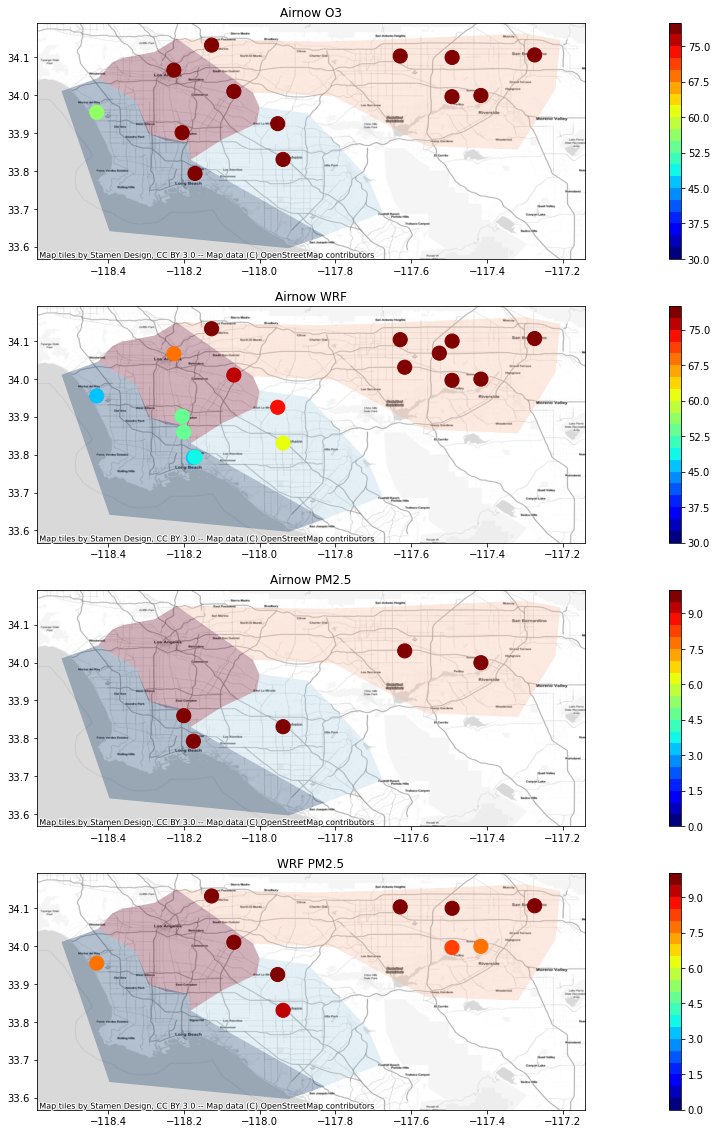

In [ ]:
#map
space_avg = space_avg.query('cls_indxs<5')
vmax = 80
vmin = 30

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap('jet',nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,figsize=(30, 20))

shapefile.plot(ax=ax1, alpha = 0.3, cmap='RdBu', legend=True)
space_avg.plot(ax=ax1, column = 'OZONE', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, linewidth = 1,norm=norm)
cx.add_basemap(ax1,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)
ax1.set_title('Airnow O3')

shapefile.plot(ax=ax2,alpha = 0.3, cmap='RdBu', legend=True)
space_avg.plot(ax=ax2, column = 'o3', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, norm=norm)
cx.add_basemap(ax2,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)
ax2.set_title('Airnow WRF')

vmax = 10
vmin = 0

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap('jet',nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


shapefile.plot(ax=ax3,alpha = 0.3, cmap='RdBu', legend=True)
space_avg.plot(ax=ax3, column = 'PM2.5', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, norm=norm)
cx.add_basemap(ax3,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)
ax3.set_title('Airnow PM2.5')

shapefile.plot(ax=ax4,alpha = 0.3, cmap='RdBu', legend=True)
space_avg.plot(ax=ax4, column = 'PM2_5_DRY', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, norm=norm)
cx.add_basemap(ax4,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)
ax4.set_title('WRF PM2.5')
#plt.legend()


In [14]:
pair_obss = ['OZONE','PM2.5']
pair_wrfs = ['o3','PM2_5_DRY']
pair_models = ['O3','PM2.5']

conc_df = pd.DataFrame()

this_df = pd.DataFrame()
for i in range(len(pair_models)):
    this_df.loc[:,pair_models[i]] = mda.loc[:,pair_obss[i]].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'longitude'] = mda.loc[:,'longitude']
this_df.loc[:,'area'] = mda.loc[:,'area'].values
this_df.loc[:,'cls_indxs'] = mda.loc[:,'cls_indxs'].values
this_df.loc[:,'scale'] = mda.loc[:,'scale'].values
conc_df = pd.concat([conc_df, this_df])

this_df = pd.DataFrame()
for i in range(len(pair_models)):
    this_df.loc[:,pair_models[i]] = mda.loc[:,pair_wrfs[i]].values
this_df.loc[:,'data_index'] = 1
this_df.loc[:,'longitude'] = mda.loc[:,'longitude']
this_df.loc[:,'area'] = mda.loc[:,'area'].values
this_df.loc[:,'cls_indxs'] = mda.loc[:,'cls_indxs'].values
this_df.loc[:,'scale'] = mda.loc[:,'scale'].values
conc_df = pd.concat([conc_df, this_df])


#this_df = pd.DataFrame()
#this_df.loc[:,pair_model] = mda.loc[:,pair_wrf].values
#this_df.loc[:,'data_index'] = 1
#this_df.loc[:,'longitude'] = mda.loc[:,'longitude']
#this_df.loc[:,'area'] = mda.loc[:,'area'].values
#this_df.loc[:,'cls_indxs'] = mda.loc[:,'cls_indxs'].values
#this_df.loc[:,'scale'] = mda.loc[:,'scale'].values
#conc_df = pd.concat([conc_df, this_df])


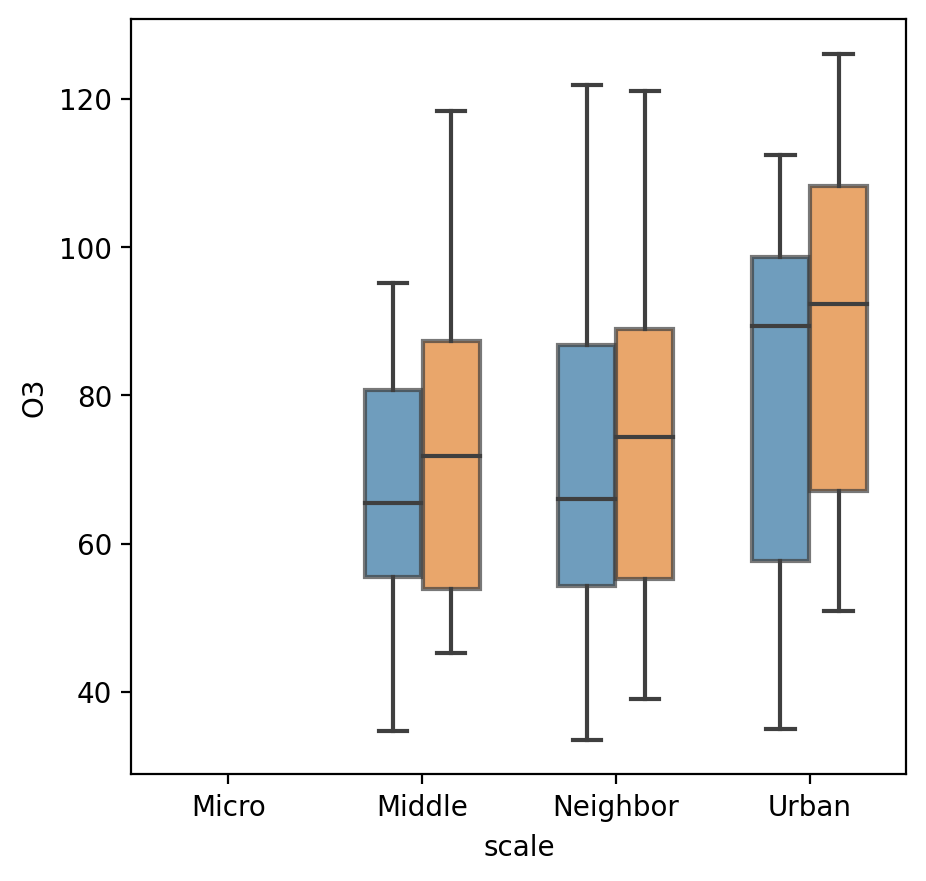

In [15]:
#conc_df = conc_df.query('cls_indxs<5')
box_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:blue','tab:orange','tab:green']
fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='scale',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs,order= ['Micro','Middle','Neighbor','Urban'])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs.tick_params(axis='x', labelrotation = 0)

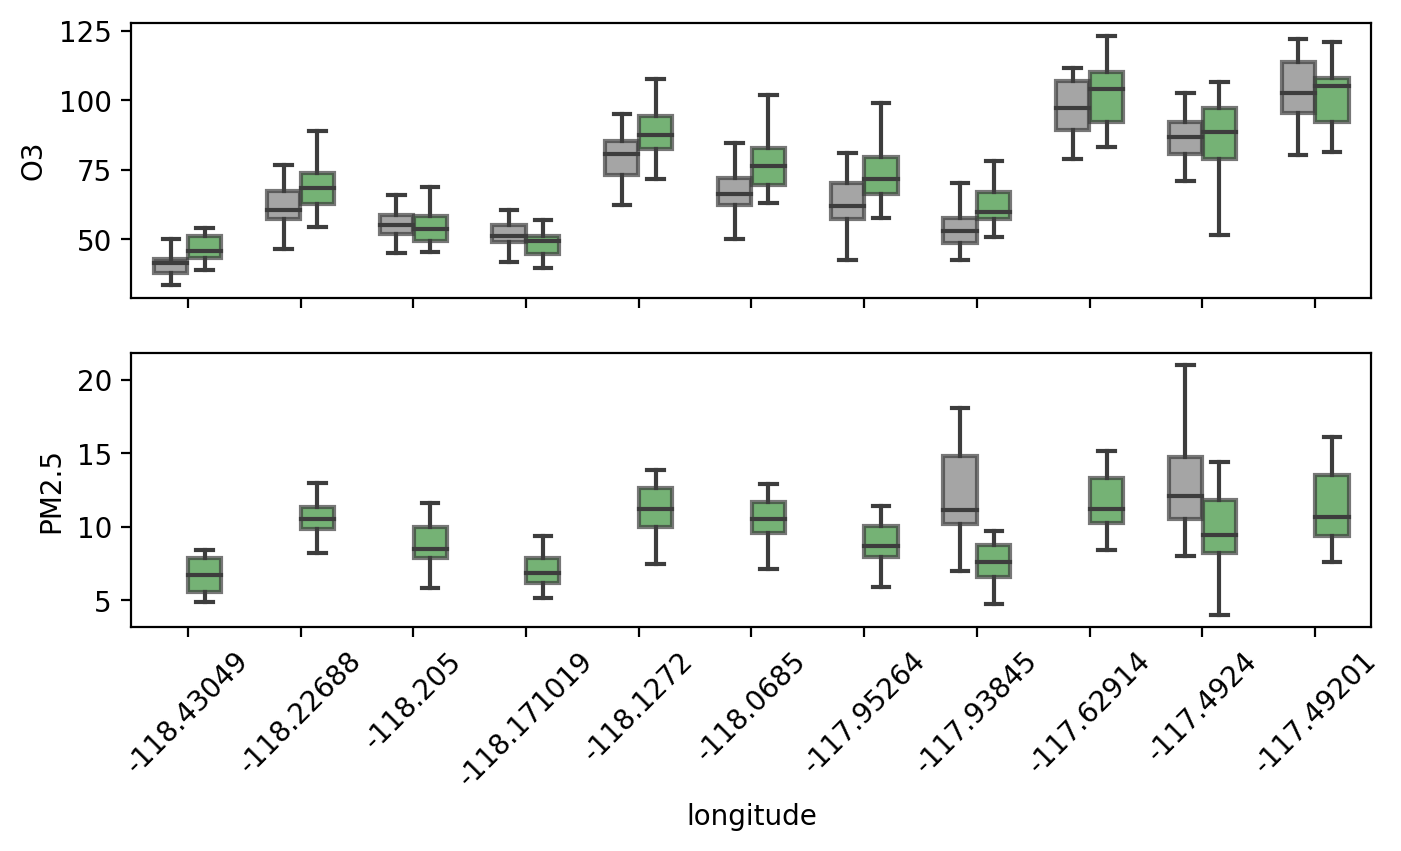

In [16]:

box_colors = ['tab:gray','tab:green']
conc_df = conc_df.query('cls_indxs<5')

fig, axs = plt.subplots(2,1,figsize=(8,4),dpi=200)
#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='longitude',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[0])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
bplot.set(xlabel=None)
bplot.set(xticklabels=[]) 
#axs[0].tick_params(axis='x', labelrotation = 45)

bplot = sns.boxplot(x='longitude',y='PM2.5', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs[1])
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs[1].tick_params(axis='x', labelrotation = 45)


index      OZONE          o3  PM2_5_DRY      PM2.5  \
longitude                                                              
-118.430490   33.789474  43.144737   46.279999   6.447046        NaN   
-118.226880   94.789474  62.901316   69.835951  10.292862        NaN   
-118.205000  155.789474  56.539474   55.276944   8.583535        NaN   
-118.171019  216.789474  51.822368   48.347314   6.967138        NaN   
-118.127200  277.789474  80.072368   90.374848  11.163101        NaN   
-118.068500  338.789474  68.486842   78.332113   9.681773        NaN   
-117.952640  399.789474  63.388158   75.084419   8.623084        NaN   
-117.938450  460.789474  52.993421   62.323091   6.994472  12.734399   
-117.629140  643.789474  92.802631  102.770918  10.982990        NaN   
-117.492400  704.789474  85.539474   90.895816   9.603307        NaN   
-117.492010  765.789474  92.723684  100.454655  11.233267        NaN   
-117.416010  823.533333  81.116667   82.624823   9.759888  13.315476   
-117.274063  884.608696  98.413043   99.175552  11.165453        NaN   

                   TEMP   latitude        day   weekday  cls_indxs  
longitude                                                           
-118.430490 -274.160000  33.955070  19.000000  5.473684        3.0  
-118.226880 -139.518333  34.066590  19.000000  5.473684        0.0  
-118.205000   25.194678  33.901389  19.000000  5.473684        0.0  
-118.171019   23.835029  33.793713  19.000000  5.473684        3.0  
-118.127200 -274.160000  34.132600  19.000000  5.473684        1.0  
-118.068500 -274.160000  34.010290  19.000000  5.473684        0.0  
-117.952640   27.701988  33.925130  19.000000  5.473684        2.0  
-117.938450   25.965877  33.830620  19.000000  5.473684        2.0  
-117.629140 -274.160000  34.103740  19.000000  5.473684        1.0  
-117.492400 -274.160000  33.996360  19.000000  5.473684        1.0  
-117.492010   32.581740  34.100020  19.000000  5.473684        1.0  
-117.416010 -274.160000  33.999580  15.533333  5.600000        1.0  
-117.274063 -274.160000  34.106678  15.956522  5.565217        1.0

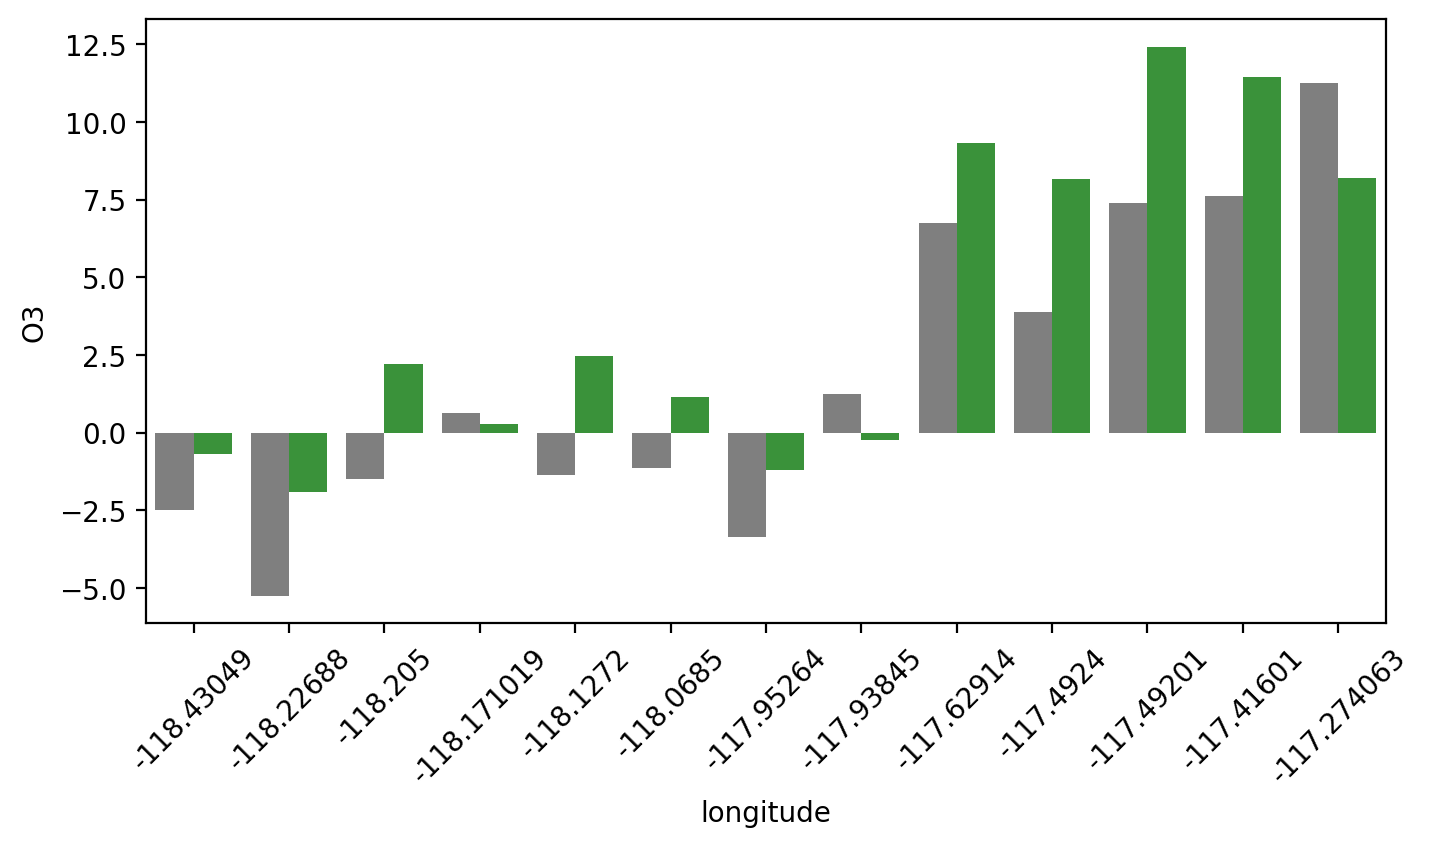

In [43]:
pair_obs = 'OZONE'
pair_wrf = 'o3'
pair_model = 'O3'
conc_df = pd.DataFrame()

indx = mda.loc[:,'weekday']<5
this_mda_weekday = mda.loc[indx,:].reset_index().groupby('longitude').median()
indx = mda.loc[:,'weekday']>=5
this_mda_weekend = mda.loc[indx,:].reset_index().groupby('longitude').median()

this_df = pd.DataFrame()
this_df.loc[:,pair_model] = this_mda_weekday.loc[:,pair_obs].values-this_mda_weekend.loc[:,pair_obs].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda_weekday.reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekday.loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])


this_df = pd.DataFrame()
this_df.loc[:,pair_model] = this_mda_weekday.loc[:,pair_wrf].values - this_mda_weekend.loc[:,pair_wrf].values
this_df.loc[:,'data_index'] = 1
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = this_mda_weekday.reset_index().loc[:,'longitude']

this_df.loc[:,'cls_indxs'] = this_mda_weekday.loc[:,'cls_indxs'].values
conc_df = pd.concat([conc_df, this_df])

box_colors = ['tab:gray','tab:green']
conc_df = conc_df.query('cls_indxs<5')

ymaxs=[130]
ymins=[10]

i=0
fig, axs = plt.subplots(1,1,figsize=(8,4),dpi=200)

#for min_vals in [-0.3, 0.7, 1.7, 2.7, 3.7, 4.7, 5.7,6.7,7.7,8.7,9.7,10.7,11.7]:
#    axs.fill_between([min_vals,min_vals+0.3],[ymins[i],ymins[i]],[ymaxs[i],ymaxs[i]], facecolor='tab:gray',edgecolor='None',alpha=0.1)
#    axs.fill_between([min_vals+0.3,min_vals+0.6],[ymins[i],ymins[i]],[ymaxs[i],ymaxs[i]], facecolor='tab:green',edgecolor='None',alpha=0.05)

#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.barplot(x='longitude',y='O3', hue='con_index', data=conc_df, palette=box_colors, ax=axs)
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
#axs.set_ylim([25,130])
axs.tick_params(axis='x', labelrotation = 45)

In [18]:
pair_obs = 'OZONE'
pair_wrf = 'o3'
pair_model = 'O3'
conc_df = pd.DataFrame()

indx = mda.loc[:,'weekday']<5
this_mda = mda.loc[indx,:].reset_index()
this_df = pd.DataFrame()
this_df.loc[:,pair_model] = this_mda.loc[:,pair_obs].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 0
this_df.loc[:,'longitude'] = this_mda.loc[:,'longitude']
this_df.loc[:,'area'] = this_mda.loc[:,'area'].values
this_df.loc[:,'cls_indxs'] = this_mda.loc[:,'cls_indxs'].values
this_df.loc[:,'scale'] = this_mda.loc[:,'scale'].values
conc_df = pd.concat([conc_df, this_df])

indx = mda.loc[:,'weekday']>=5
this_mda = mda.loc[indx,:].reset_index()
this_df = pd.DataFrame()
this_df.loc[:,pair_model] = this_mda.loc[:,pair_obs].values
this_df.loc[:,'data_index'] = 0
this_df.loc[:,'weekday_index'] = 1
this_df.loc[:,'con_index'] = 1
this_df.loc[:,'longitude'] = this_mda.loc[:,'longitude']
this_df.loc[:,'area'] = this_mda.loc[:,'area'].values
this_df.loc[:,'cls_indxs'] = this_mda.loc[:,'cls_indxs'].values
this_df.loc[:,'scale'] = this_mda.loc[:,'scale'].values
conc_df = pd.concat([conc_df, this_df])

indx = mda.loc[:,'weekday']<5
this_mda = mda.loc[indx,:].reset_index()
this_df = pd.DataFrame()
this_df.loc[:,pair_model] = this_mda.loc[:,pair_wrf].values
this_df.loc[:,'data_index'] = 1
this_df.loc[:,'weekday_index'] = 0
this_df.loc[:,'con_index'] = 2
this_df.loc[:,'longitude'] = this_mda.loc[:,'longitude']
this_df.loc[:,'area'] = this_mda.loc[:,'area'].values
this_df.loc[:,'cls_indxs'] = this_mda.loc[:,'cls_indxs'].values
this_df.loc[:,'scale'] = this_mda.loc[:,'scale'].values
conc_df = pd.concat([conc_df, this_df])

indx = mda.loc[:,'weekday']>=5
this_mda = mda.loc[indx,:].reset_index()
this_df = pd.DataFrame()
this_df.loc[:,pair_model] = this_mda.loc[:,pair_wrf].values
this_df.loc[:,'data_index'] = 1
this_df.loc[:,'weekday_index'] = 1
this_df.loc[:,'con_index'] = 3
this_df.loc[:,'longitude'] = this_mda.loc[:,'longitude']
this_df.loc[:,'area'] = this_mda.loc[:,'area'].values
this_df.loc[:,'cls_indxs'] = this_mda.loc[:,'cls_indxs'].values
this_df.loc[:,'scale'] = this_mda.loc[:,'scale'].values
conc_df = pd.concat([conc_df, this_df])


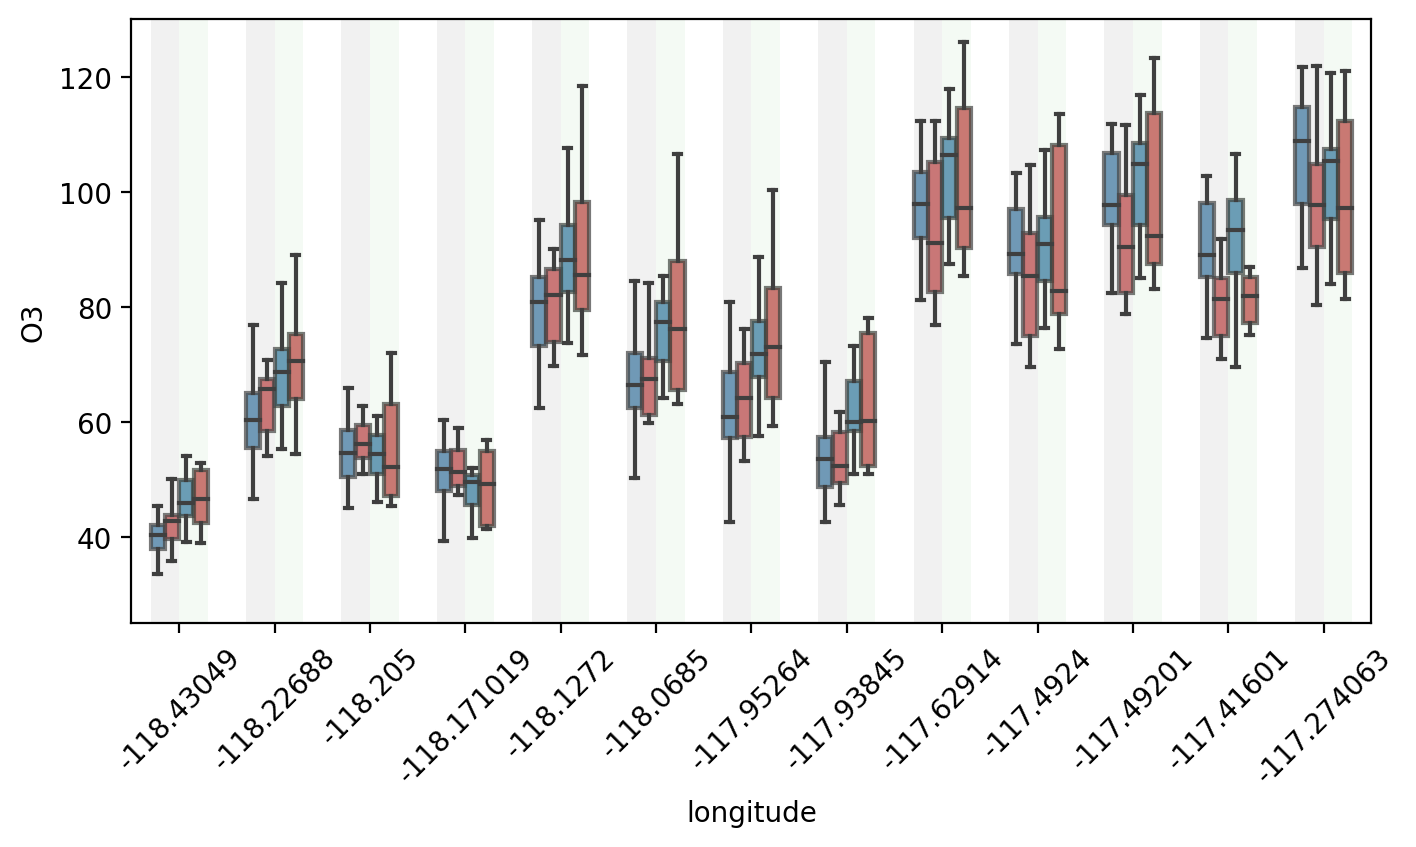

In [19]:
box_colors = ['tab:blue','tab:red','tab:blue','tab:red']
conc_df = conc_df.query('cls_indxs<5')

ymaxs=[130]
ymins=[10]

i=0
fig, axs = plt.subplots(1,1,figsize=(8,4),dpi=200)

for min_vals in [-0.3, 0.7, 1.7, 2.7, 3.7, 4.7, 5.7,6.7,7.7,8.7,9.7,10.7,11.7]:
    axs.fill_between([min_vals,min_vals+0.3],[ymins[i],ymins[i]],[ymaxs[i],ymaxs[i]], facecolor='tab:gray',edgecolor='None',alpha=0.1)
    axs.fill_between([min_vals+0.3,min_vals+0.6],[ymins[i],ymins[i]],[ymaxs[i],ymaxs[i]], facecolor='tab:green',edgecolor='None',alpha=0.05)

#conc_df = concatenate_df('O3', 'OZONE', 'o3')
#conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='longitude',y='O3', hue='con_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs)
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs.set_ylim([25,130])
axs.tick_params(axis='x', labelrotation = 45)


(array([18779., 18783., 18787., 18791., 18795., 18799., 18803., 18807.,
        18809.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

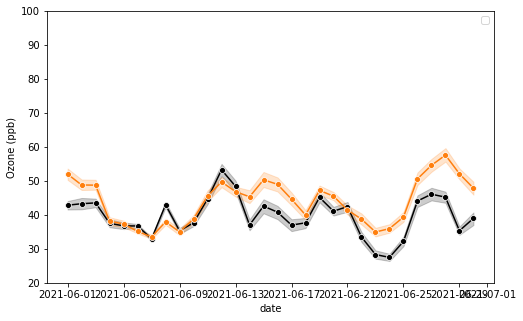

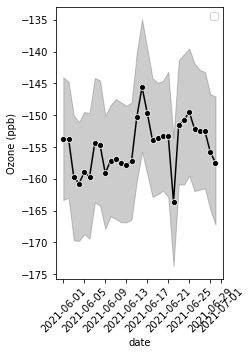

In [44]:
colors = ['tab:orange','tab:green','tab:purple','tab:green']

plt.figure(figsize=(8,5))
sns.lineplot(x='date',y='OZONE',data=gdfs[0].query('month == 6'),label='AIRNOW',color='k',marker='o')
for i in range(len(wrf_files)):
    sns.lineplot(x='date',y='o3',data=gdfs[i].query('month == 6'),label='RACM_ESRL_VCP',color=colors[i],marker='o')
plt.legend([],[])
plt.ylim([20,100])
plt.ylabel('Ozone (ppb)')

plt.figure(figsize=(3,5))
sns.lineplot(x='date',y='TEMP',data=gdfs[0].query('month == 6'),label='AIRNOW',color='k',marker='o')
plt.legend([],[])

plt.ylabel('Ozone (ppb)')
plt.xticks(rotation = 45)

In [25]:
space_avgs = []
for i in range(len(wrf_files)):
    #indx = gdfs[i].loc[:,'cls_indxs']<5
    gdfs[i] = gdfs[i].loc[indx,:]
    space_avg = gdfs[i].groupby('siteid').agg('mean')
    space_avg = gpd.GeoDataFrame(
        space_avg, geometry=gpd.points_from_xy(space_avg['longitude'], space_avg['latitude']))
    space_avgs.append(space_avg)

In [26]:
space_avgs[0][['o3','OZONE']]

o3      OZONE
siteid                        
60370002  80.550306  68.338028
60371103  54.075074  52.819444
60371302  47.047729  47.013889
60371602  55.373320  53.430555
60371701  78.482287  67.680555
60372005  61.589608  63.736111
60374009  47.412899  46.152778
60375005  45.124864  35.027778
60590007  53.758512  44.236111
60595001  58.083728  49.375000
60658001  76.428901  68.117647
60658005  78.868314  69.402778
60711004  82.419740  76.736111
60712002  84.511898  78.305555
60719004  85.272667  85.453125

IndexError: list index out of range

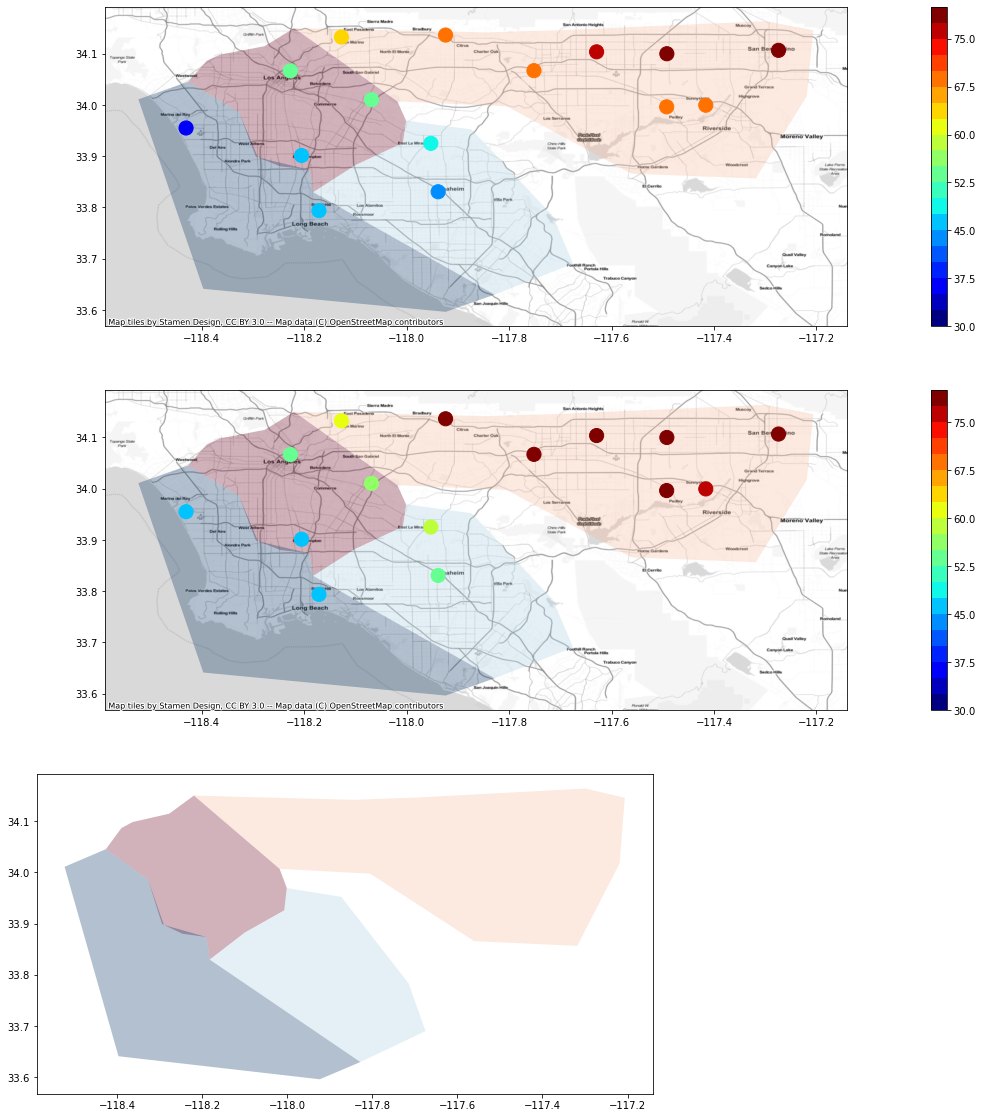

In [27]:
#map
vmax = 80
vmin = 30

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap('jet',nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(30, 20))

shapefile.plot(ax=ax1, alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[0].plot(ax=ax1, column = 'OZONE', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, linewidth = 1,norm=norm)
cx.add_basemap(ax1,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)

shapefile.plot(ax=ax2,alpha = 0.3, cmap='RdBu', legend=True)
space_avgs[0].plot(ax=ax2, column = 'o3', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, norm=norm)
cx.add_basemap(ax2,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)
#plt.legend()


shapefile.plot(ax=ax3, alpha = 0.3, cmap='RdBu', legend=True)

space_avgs[1].plot(ax=ax3, column = 'o3', cmap = cmap,
            legend = True, legend_kwds={'shrink': 1}, 
            markersize = 200, norm=norm)
cx.add_basemap(ax3,crs='epsg:4326', source=cx.providers.Stamen.TonerLite)
#plt.legend()
plt.show()

In [28]:
#diff
for i in range(2):
    space_avgs[i]['diff'] = space_avgs[i]['o3'] -  space_avgs[i]['OZONE'] 


vmax = 20
vmin = -20

nlevels = 21
clevel = np.linspace(vmin,vmax,nlevels)
cmap = mpl.cm.get_cmap('coolwarm',nlevels-1) 
norm = mpl.colors.BoundaryNorm(clevel, ncolors=cmap.N, clip=False)


fig, axs = plt.subplots(nrows=2,figsize=(30, 20))

for i in range(2):
    shapefile.plot(ax=axs[i], alpha = 0.1, cmap='summer', legend=True)
    space_avgs[i].plot(ax=axs[i], column = 'diff', cmap = cmap,
                legend = True, legend_kwds={'shrink': 1}, 
                markersize = 500, linewidth = 1,norm=norm)
    

    cx.add_basemap(axs[i],crs='epsg:4326', source=cx.providers.Stamen.TonerLite)

    #plt.legend()
plt.show()

IndexError: list index out of range

In [29]:
def concatenate_df(pair_model, pair_obs, pair_wrf):
    conc_df = pd.DataFrame()

    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = gdfs[0].loc[:,pair_obs].values
    this_df.loc[:,'data_index'] = 0
    this_df.loc[:,'siteid'] = gdfs[0].loc[:,'siteid']
    this_df.loc[:,'longitude'] = gdfs[0].loc[:,'longitude']
    this_df.loc[:,'area'] = gdfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = gdfs[0].loc[:,'cls_indxs'].values
    conc_df = pd.concat([conc_df, this_df])
    
    for i in range(len(gdfs)):
        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = gdfs[i].loc[:,pair_wrf].values
        this_df.loc[:,'data_index'] = i+1
        this_df.loc[:,'siteid'] = gdfs[i].loc[:,'siteid']
        this_df.loc[:,'longitude'] = gdfs[i].loc[:,'longitude']
        this_df.loc[:,'area'] = gdfs[i].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = gdfs[i].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
    return conc_df

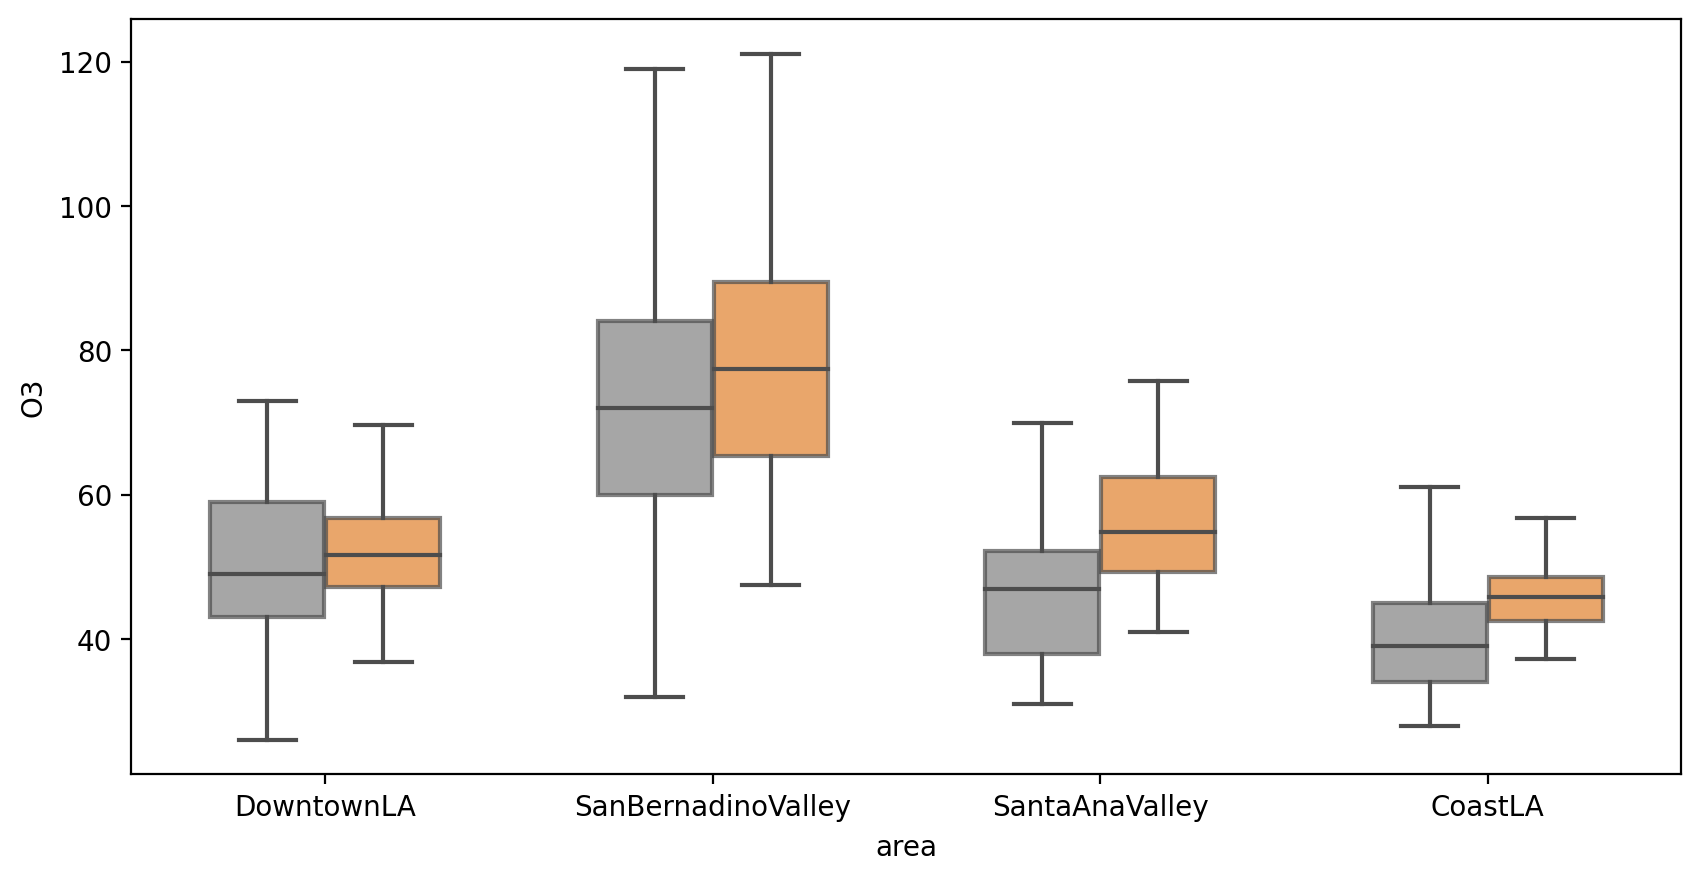

In [30]:
conc_df = concatenate_df('O3', 'OZONE', 'o3')
conc_df = conc_df.query('cls_indxs<5')
box_colors = ['gray','tab:orange','tab:green']
labels = ['SUNVEX Mobile', 'RACM2_BERK_SILX_IVOC 12km', 'RACM2_BERK_SILX_IVOC 4km']

fig, axs = plt.subplots(1,1,figsize=(10,5),dpi=200)

bplot = sns.boxplot(x='area',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7),
                        order = ['DowntownLA', 'SanBernadinoValley', 'SantaAnaValley', 'CoastLA'], ax=axs)

bplot.get_legend().remove()

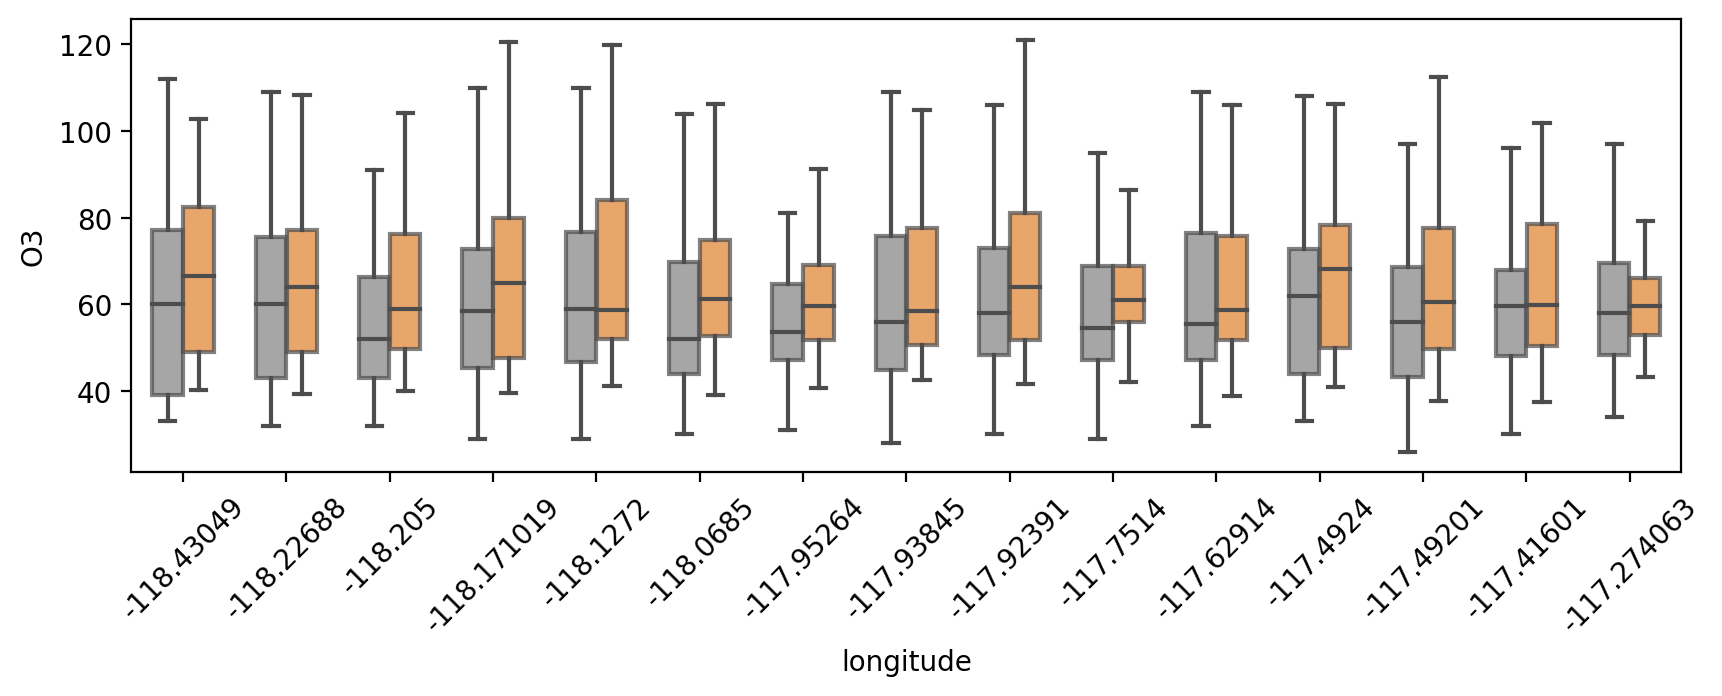

In [31]:
fig, axs = plt.subplots(1,1,figsize=(10,3),dpi=200)
conc_df = concatenate_df('O3', 'OZONE', 'o3')
conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='longitude',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs)
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs.tick_params(axis='x', labelrotation = 45)

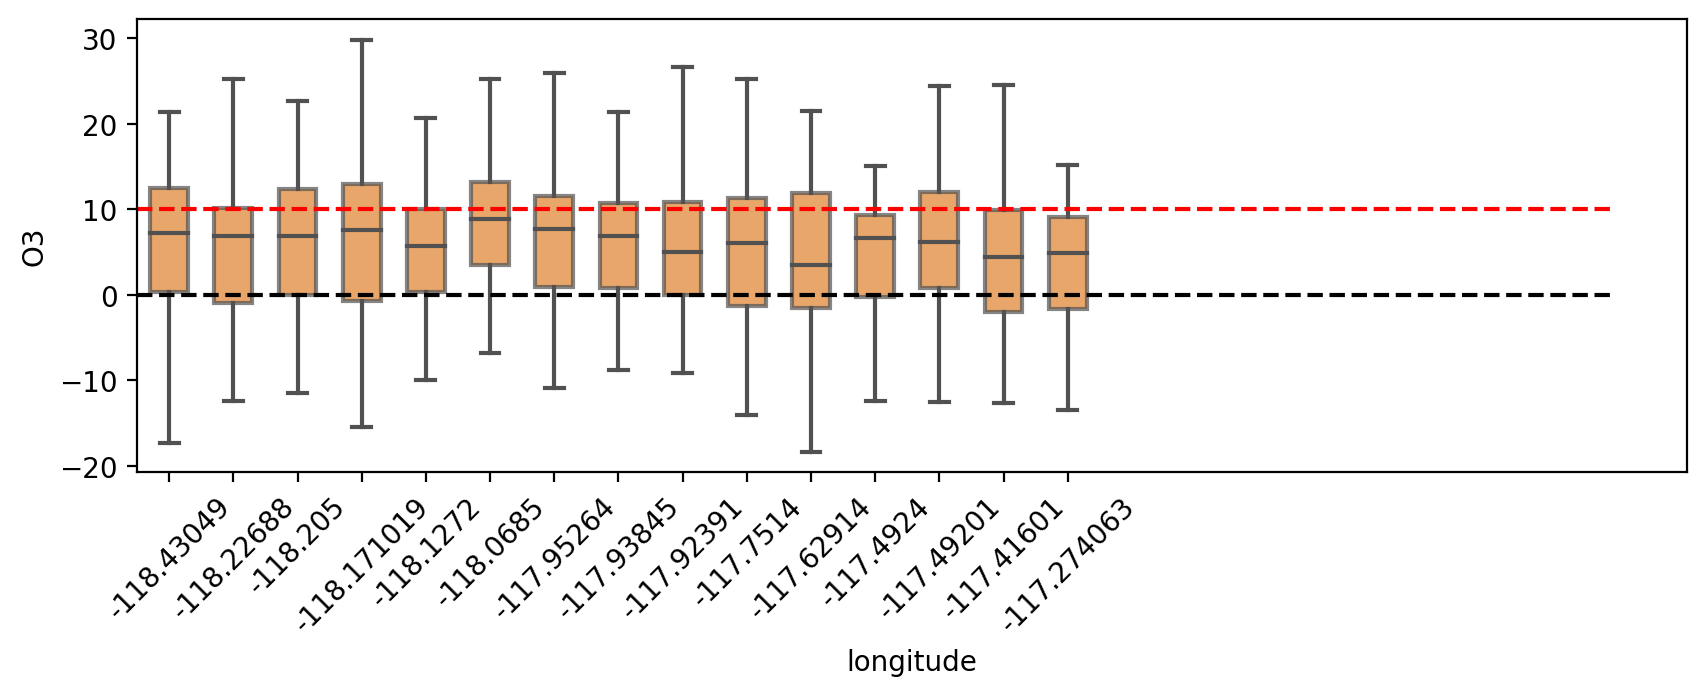

In [21]:
def concatenate_df_diff(pair_model, pair_obs, pair_wrf):
    conc_df = pd.DataFrame()

    
    for i in range(len(gdfs)):
        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = gdfs[i].loc[:,pair_wrf].values - gdfs[i].loc[:,pair_obs].values 
        this_df.loc[:,'data_index'] = i+1
        this_df.loc[:,'siteid'] = gdfs[i].loc[:,'siteid']
        this_df.loc[:,'longitude'] = gdfs[i].loc[:,'longitude']
        this_df.loc[:,'area'] = gdfs[i].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = gdfs[i].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
    return conc_df

box_colors = ['tab:orange','tab:green']
fig, axs = plt.subplots(1,1,figsize=(10,3),dpi=200)
conc_df = concatenate_df_diff('O3', 'OZONE', 'o3')
conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='longitude',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs)
sns.lineplot(x=[-0.5,22.5],y=[0,0],color='k',linestyle='--')
sns.lineplot(x=[-0.5,22.5],y=[10,10],color='red',linestyle='--')
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs.tick_params(axis='x', labelrotation = 45)

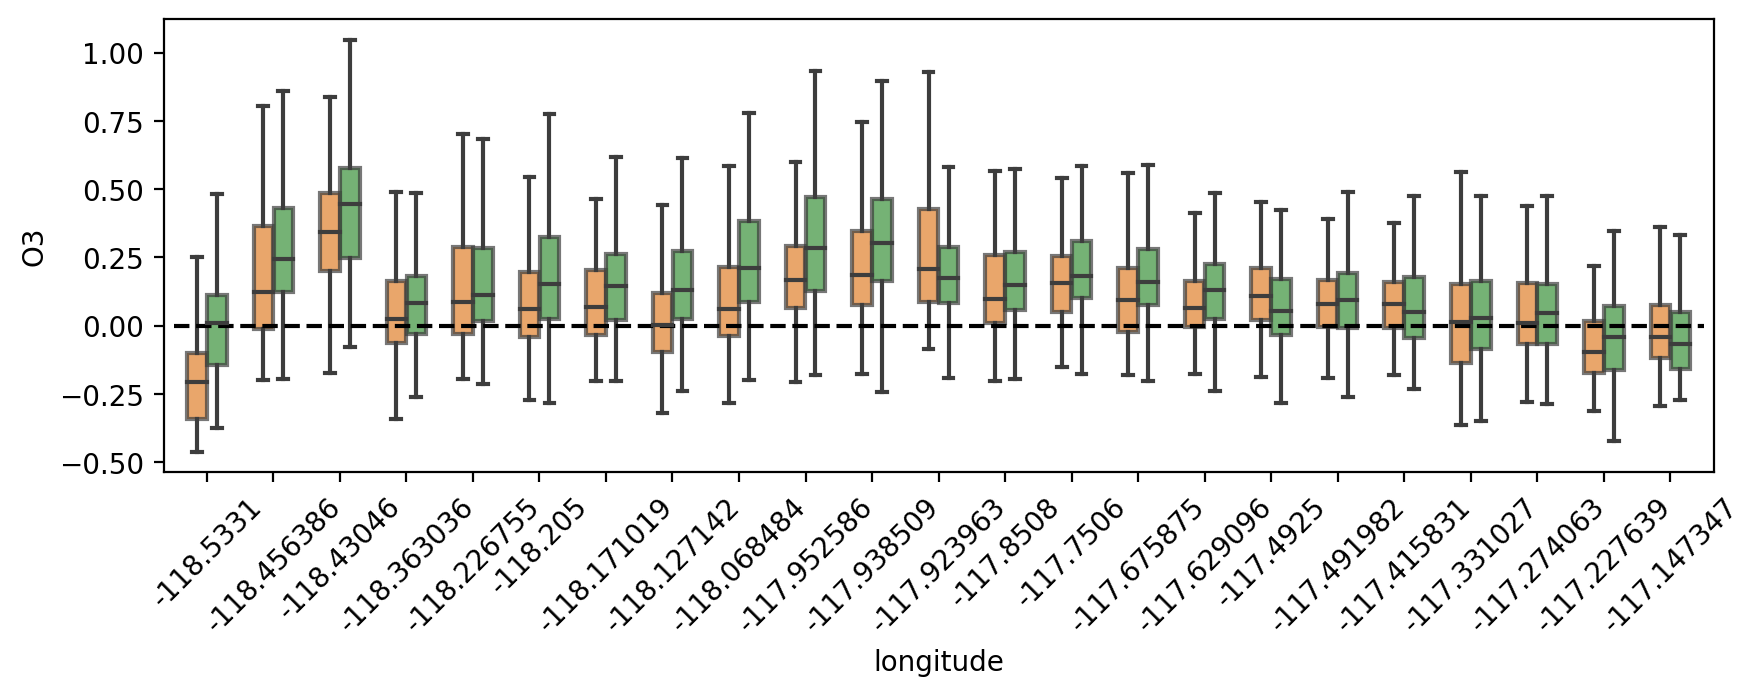

In [47]:
def concatenate_df_rel_diff(pair_model, pair_obs, pair_wrf):
    conc_df = pd.DataFrame()

    
    for i in range(len(gdfs)):
        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = (gdfs[i].loc[:,pair_wrf].values - gdfs[i].loc[:,pair_obs].values)/gdfs[i].loc[:,pair_obs].values
        this_df.loc[:,'data_index'] = i+1
        this_df.loc[:,'siteid'] = gdfs[i].loc[:,'siteid']
        this_df.loc[:,'longitude'] = gdfs[i].loc[:,'longitude']
        this_df.loc[:,'area'] = gdfs[i].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = gdfs[i].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
    return conc_df

box_colors = ['tab:orange','tab:green']
fig, axs = plt.subplots(1,1,figsize=(10,3),dpi=200)
conc_df = concatenate_df_rel_diff('O3', 'OZONE', 'o3')
conc_df = conc_df.reset_index().sort_values(by='longitude')
bplot = sns.boxplot(x='longitude',y='O3', hue='data_index', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), ax=axs)
sns.lineplot(x=[-0.5,22.5],y=[0,0],color='k',linestyle='--')
#sns.lineplot(x=[-0.5,22.5],y=[0.25,0.25],color='red',linestyle='--')
#axs.set_xticklabels(axs.get_xticks(), rotation = 45)
bplot.get_legend().remove()
axs.tick_params(axis='x', labelrotation = 45)


<AxesSubplot:xlabel='data_index', ylabel='O3'>

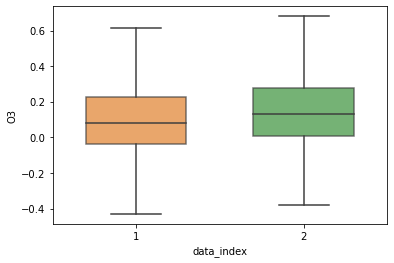

In [69]:
sns.boxplot(x='data_index',y='O3', data=conc_df, 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7))

/Users/zhu/opt/anaconda3/envs/py39_recap_def/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zhu/opt/anaconda3/envs/py39_recap_def/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 6.79999999999999, '(Model O3 - Obs O3)/Obs O3')

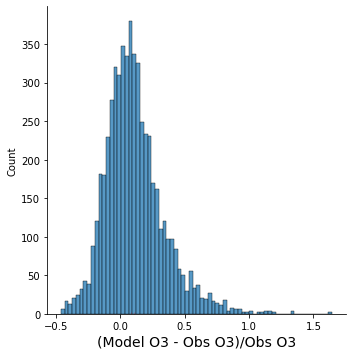

In [67]:
sns.displot(x='O3',data=conc_df.query('data_index==1'),fill=True)
sns.lineplot([0.11,0.11],[0,2.2], linestyle='-',color='r',linewidth = 10)
sns.lineplot([0.08,0.08],[0,2.2], linestyle='-',color='r',linewidth = 10)
plt.xlabel('(Model O3 - Obs O3)/Obs O3',fontsize=14)

In [12]:
# correct racetrack
sites_info = gdfs[1].groupby(['siteid'])['longitude','latitude'].agg('mean').reset_index('siteid')

/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_72094/4108709147.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sites_info = gdfs[1].groupby(['siteid'])['longitude','latitude'].agg('mean').reset_index('siteid')


In [24]:
dates

array([datetime.date(2021, 6, 1), datetime.date(2021, 6, 4),
       datetime.date(2021, 6, 6), datetime.date(2021, 6, 10),
       datetime.date(2021, 6, 11), datetime.date(2021, 6, 12),
       datetime.date(2021, 6, 18), datetime.date(2021, 6, 19),
       datetime.date(2021, 6, 21)], dtype=object)

In [25]:
#df_wrf = pd.read_csv('/Users/zhu/Dropbox/Database/Hera/racetrack/racetrack-recap-wrf-chem-racm2-berk-vcp-4km.csv')
df_wrf = pd.read_csv('/Users/zhu/Dropbox/Database/Hera/racetrack/racetrack-recap-wrf-chem-racm-esrl-vcp-4km.csv')
df_wrf['date'] = pd.to_datetime(df_wrf['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.date
df_wrf['hour'] = pd.to_datetime(df_wrf['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.hour
dates = df_wrf['date'].unique()
ozone_ratios = [] 
ozone_obs = []
ozone_model = []
for i in range(len(dates)):
    this_df_wrf = df_wrf[df_wrf['date'] == dates[i]]
    this_long = this_df_wrf['longitude'].mean()
    this_lat = this_df_wrf['latitude'].mean()
    closet_hour = np.quantile(this_df_wrf['hour'],0.5)
    #find the closest sites
    dist = (sites_info['longitude'].values - this_long)**2 + (sites_info['latitude'].values - this_lat)**2

    this_siteid = sites_info.iloc[np.argmin(dist),:]['siteid']
    
    this_gdf = gdfs[1]
    indx = (this_gdf['date'] == dates[0]) & (this_gdf['siteid'] == this_siteid) & (this_gdf['hour'] == closet_hour)

    this_gdf = this_gdf[indx]
    ozone_ratios.append(this_gdf['OZONE'].values[0]/this_gdf['o3'].values[0])
    ozone_obs.append(this_gdf['OZONE'].values[0])
    ozone_model.append(this_gdf['o3'].values[0])
poh_correct_ratios = pd.DataFrame()
poh_correct_ratios['date'] = dates
poh_correct_ratios['o3_obs_mod_ratio'] = ozone_ratios

In [27]:
ozone_ratios

[1.157773165709194,
 1.1828302892837441,
 0.8483320630821819,
 0.7310171644506092,
 0.8162286716379727,
 0.7310171644506092,
 0.8162286716379727,
 0.7096764544510815,
 0.8145369705897609]

<AxesSubplot:>

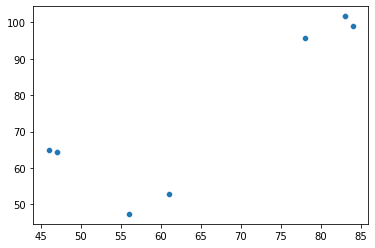

In [26]:
sns.scatterplot(x=ozone_obs,y=ozone_model)

In [23]:
poh_correct_ratios.to_csv('./Output/Ozone-obs-model-ratio-wrf-chem-racm-esrl-vcp-4km.csv')
#poh_correct_ratios.to_csv('./Output/Ozone-obs-model-ratio-wrf-chem-racm2-berk-vcp-4km.csv')

In [145]:
df_wrf = pd.read_csv('/Users/zhu/Dropbox/Database/Hera/recap-wrf-chem-racm-esrl-vcp.csv')
df_wrf['date'] = pd.to_datetime(df_wrf['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.date
df_wrf['hour'] = pd.to_datetime(df_wrf['time']).dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.hour
dates = df_wrf['date'].unique()
ozone_ratios = [] 
for i in range(len(dates)):
    this_df_wrf = df_wrf[df_wrf['date'] == dates[i]]
    this_long = this_df_wrf['longitude'].mean()
    this_lat = this_df_wrf['latitude'].mean()
    closet_hour = np.quantile(this_df_wrf['hour'],0.5)
    #find the closest sites
    dist = (sites_info['longitude'].values - this_long)**2 + (sites_info['latitude'].values - this_lat)**2

    this_siteid = sites_info.iloc[np.argmin(dist),:]['siteid']
    
    this_gdf = gdfs[0]
    indx = (this_gdf['date'] == dates[0]) & (this_gdf['siteid'] == this_siteid) & (this_gdf['hour'] == closet_hour)

    this_gdf = this_gdf[indx]
    ozone_ratios.append(this_gdf['OZONE'].values[0]/this_gdf['o3'].values[0])
poh_correct_ratios = pd.DataFrame()
poh_correct_ratios['date'] = dates
poh_correct_ratios['o3_obs_mod_ratio'] = ozone_ratios

In [147]:
poh_correct_ratios.to_csv('./Output/Ozone-obs-model-ratio-wrf-chem-racm-esrl-vcp.csv')

1.0643595403792088